In [8]:
# Data handling
import pandas as pd
import numpy as np

# Visualisatie
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-means clustering
from sklearn.cluster import KMeans

# Hiërarchisch clusteren
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Dimensionaliteitsreductie
from sklearn.manifold import TSNE
import umap  # LET OP: installeren met pip install umap-learn

# Genereren van synthetische data
from sklearn.datasets import make_blobs, make_circles, make_gaussian_quantiles, make_moons

# Evaluatie-metrics
from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
    silhouette_samples,
    adjusted_rand_score
)

# Voor bootstrapping
from sklearn.utils import resample

# Statistische testen
from scipy.stats import chi2_contingency, kruskal

# Seaborn stijl instellen
sns.set_style('darkgrid')

import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample 

import pandas as pd
from scipy.stats import kruskal, pearsonr


In [9]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


In [ ]:
df = pd.read_csv(r"C:\Users\lucas\OneDrive\Jaar 5\Stat5\college_math.csv")
df_heel = df
useless_var = ["age", "gender",'commute_minutes','grade_period1','grade_period2','past_failures','health_status','support_family']
df = df.drop(columns=useless_var)

In [11]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df

alcohol_weekday  alcohol_weekend  extra_paid_classes  free_time  \
0               0.00             0.00                 0.0       1.00   
1               0.25             0.25                 0.0       0.25   
2               0.50             0.50                 0.0       0.75   
3               0.00             0.00                 1.0       0.50   
4               0.00             0.00                 0.0       0.75   
..               ...              ...                 ...        ...   
568             0.50             0.75                 1.0       0.25   
569             0.00             0.00                 0.0       0.25   
570             0.00             0.50                 0.0       0.50   
571             0.00             0.25                 0.0       1.00   
572             0.00             0.00                 0.0       0.50   

     grade_final  internet_access  school_absences  social_outings  \
0       0.888889              0.0           0.0000            0.50   
1       0.000000              0.0           0.0000            0.75   
2       0.333333              1.0           0.1000            0.75   
3       0.666667              1.0           0.0000            0.50   
4       0.611111              1.0           0.2500            0.75   
..           ...              ...              ...             ...   
568     0.833333              1.0           0.1625            1.00   
569     0.000000              0.0           0.0000            0.00   
570     0.666667              1.0           0.1375            0.50   
571     0.555556              0.0           0.0000            0.50   
572     0.222222              0.0           0.0500            0.75   

     support_school  weekly_study_hours  
0               0.0            0.069444  
1               0.0            0.256944  
2               0.0            0.111111  
3               0.0            0.826389  
4               0.0            0.291667  
..              ...                 ...  
568             0.0            0.166667  
569             0.0            0.138889  
570             0.0            0.152778  
571             0.0            0.298611  
572             1.0            0.111111  

[573 rows x 10 columns]

In [12]:
results = []

for col in df.columns:
    if col == "grade_final":
        continue
    
    # Numerieke kolommen
    if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 2:
        # Pearson correlatie
        corr, p = pearsonr(df[col], df["grade_final"])
        results.append({
            "Variable": col,
            "Type": "Numeric",
            "Test": "Pearson",
            "Statistic/Correlation": corr,
            "p-value": p
        })
    else:
        # Dummy of categorisch → Kruskal-Wallis
        groups = [df["grade_final"][df[col] == val] for val in df[col].unique()]
        stat, p = kruskal(*groups)
        results.append({
            "Variable": col,
            "Type": "Categorical/Dummy",
            "Test": "Kruskal-Wallis",
            "Statistic/Correlation": stat,
            "p-value": p
        })

# Resultaten in DataFrame
results_df = pd.DataFrame(results)

# Sorteren op p-value (laagste eerst)
results_df = results_df.sort_values("p-value").reset_index(drop=True)

print(results_df)


             Variable               Type            Test  \
0  weekly_study_hours            Numeric         Pearson   
1  extra_paid_classes  Categorical/Dummy  Kruskal-Wallis   
2      social_outings            Numeric         Pearson   
3     school_absences            Numeric         Pearson   
4      support_school  Categorical/Dummy  Kruskal-Wallis   
5     internet_access  Categorical/Dummy  Kruskal-Wallis   
6     alcohol_weekend            Numeric         Pearson   
7           free_time            Numeric         Pearson   
8     alcohol_weekday            Numeric         Pearson   

   Statistic/Correlation       p-value  
0               0.251521  1.021301e-09  
1              21.905299  2.864418e-06  
2              -0.154152  2.121462e-04  
3               0.149695  3.234393e-04  
4               5.127183  2.355392e-02  
5               2.769584  9.607112e-02  
6              -0.033038  4.299177e-01  
7              -0.031126  4.571049e-01  
8              -0.027961  5.04

In [13]:
df = df.drop(columns = 'grade_final')
df1 = df

In [72]:
def k_means_elbow(df):
    inertias = []
    K_range = range(1, 7)
    n_runs = 10  # aantal herhalingen per k

    for k in K_range:
        run_inertias = []
        for _ in range(n_runs):
            model = KMeans(n_clusters=k, n_init='auto')
            model.fit(df)
            run_inertias.append(model.inertia_)
        inertias.append(np.mean(run_inertias))  # gemiddelde inertia per k

    # Elbow plot
    plt.plot(K_range, inertias, marker='o')
    plt.xlabel('Aantal clusters (k)')
    plt.ylabel('Gemiddelde inertia (WCSS)')
    plt.title(f'Elbow plot ({n_runs} runs per k, gemiddelde inertia)')
    plt.show()



def hierarchisch(df):
    combinations = [
        ("single", "euclidean"),
        ("single", "cityblock"),
        ("average", "euclidean"),
        ("average", "cityblock"),
        ("centroid", "euclidean"),
        ("ward", "euclidean")  # Ward vereist Euclidean
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for ax, (method, metric) in zip(axes, combinations):
        Z = linkage(df, method=method, metric=metric)
        dendrogram(Z, ax=ax, color_threshold=0)  # alles in één kleur
        ax.set_title(f"{method} linkage, {metric} metric")
    
    plt.tight_layout()
    plt.show()


def dendogram(df, method="ward", metric="euclidean", n_clusters=3, show_labels=False):
    """
    Maakt een dendrogram en retourneert de clusterlabels.
    
    Parameters:
    - df: pandas DataFrame of 2D array
    - method: linkage methode ('ward', 'single', 'average', etc.)
    - metric: afstandsmaat ('euclidean', 'cityblock', etc.)
    - n_clusters: aantal clusters om te visualiseren en terug te geven
    - show_labels: of de labels op de x-as getoond moeten worden (default=False)

    Returns:
    - cluster_labels: numpy array met clusterlabels voor elke sample
    """
    # Linkage matrix
    dist_matrix = pdist(df, metric=metric)
    hc = linkage(dist_matrix, method=method)
    
    # Bereken clusterlabels
    cluster_labels = fcluster(hc, t=n_clusters, criterion='maxclust')
    
    # Bepaal color_threshold (hoogte waarop boom wordt afgeknipt)
    merge_heights = np.sort(hc[:, 2])
    if n_clusters > 1:
        color_threshold = merge_heights[-(n_clusters-1)]
    else:
        color_threshold = merge_heights[-1]  # alles in 1 cluster
    
    # Plot dendrogram
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6))
    dendrogram(
        hc,
        color_threshold=color_threshold,
        labels=df.index if show_labels else None,
        leaf_rotation=90
    )
    plt.title(f"Dendrogram: {method} linkage, {metric} metric, {n_clusters} clusters")
    plt.xlabel("Samples")
    plt.ylabel(f"{metric.capitalize()} distance")
    plt.show()
    
    return cluster_labels


# functie voor uitvoeren stabiliteitsanalyse voor k-means met behulp van bootstrapping
def stability_bootstrap_kmeans(X, n_clusters=4, n_runs=50):
    scaler=MinMaxScaler
    # maak lijst aan voor bijhouden ARI-scores
    scores = []

    # zet X om naar nparray
    X = X.to_numpy()

    for _ in range(n_runs):
        # voer bootstrapping uit
        idx1 = resample(np.arange(len(X)), replace=True)
        idx2 = resample(np.arange(len(X)), replace=True)

        DF1 = X[idx1]
        DF2 = X[idx2]

        # pas scaling toe indien van toepassing
        if scaler is not None:
            DF1 = scaler().fit_transform(DF1)
            DF2 = scaler().fit_transform(DF2)
        
        # voer k-means uit
        labels1 = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(DF1)
        labels2 = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(DF2)
        
        # vergelijk clusteringen op overlappende delen
        overlap = np.intersect1d(idx1, idx2)
        if len(overlap) > 0:
            pos1 = [np.where(idx1 == i)[0][0] for i in overlap]
            pos2 = [np.where(idx2 == i)[0][0] for i in overlap]
            
            # bepaal de Adjusted Rand Index
            score = adjusted_rand_score(labels1[pos1], labels2[pos2])
            scores.append(score)

    print(f"The Adjusted Rand Index for stability of k-means is: {np.mean(scores):.3f}")
    return scores

def stability_bootstrap_hc(X, method='ward', metric='euclidean', n_clusters=4, n_runs=50):
    scaler=MinMaxScaler
    scores = []

    # zet X om naar numpy array
    X = X.to_numpy() if hasattr(X, "to_numpy") else np.array(X)

    for _ in range(n_runs):
        # bootstrap samples
        idx1 = resample(np.arange(len(X)), replace=True)
        idx2 = resample(np.arange(len(X)), replace=True)

        DF1 = X[idx1]
        DF2 = X[idx2]

        # scaling
        if scaler is not None:
            DF1 = scaler().fit_transform(DF1)
            DF2 = scaler().fit_transform(DF2)

        # clustering uitvoeren
        if method == "ward":
            Z1 = linkage(DF1, method=method)  # metric = euclidean verplicht
            Z2 = linkage(DF2, method=method)
        else:
            Z1 = linkage(DF1, method=method, metric=metric)
            Z2 = linkage(DF2, method=method, metric=metric)

        labels1 = fcluster(Z1, t=n_clusters, criterion='maxclust')
        labels2 = fcluster(Z2, t=n_clusters, criterion='maxclust')

        # overlap tussen samples vinden
        overlap = np.intersect1d(idx1, idx2)
        if len(overlap) > 0:
            pos1 = [np.where(idx1 == i)[0][0] for i in overlap]
            pos2 = [np.where(idx2 == i)[0][0] for i in overlap]

            # Adjusted Rand Index
            score = adjusted_rand_score(labels1[pos1], labels2[pos2])
            scores.append(score)

    print(f"The Adjusted Rand Index for stability of hierarchical clustering ({method}, {metric}) is: {np.mean(scores):.3f}")
    return scores

def kmeans_feature_robustness(X, n_clusters, noise_level=0.05, n_runs=50):
    scaler=MinMaxScaler
    # maak verzameling van lijsten aan voor bijhouden ARI-scores
    scores = {i: [] for i in range(X.shape[1])}

    # zet X om naar nparray
    X = X.to_numpy()

    # bepaal de standaarddeviaties
    feature_std = X.std(axis=0)

    # voer k-means op de oorspronkelijke dataset uit; pas scaling toe indien van toepassing
    if scaler is not None:
        X_scaled = scaler().fit_transform(X)
        base_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(X_scaled)
    else:
        base_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(X)

    for i in range(X.shape[1]):
        for _ in range(n_runs):
            X_perturbed = X.copy()
            noise = np.random.normal(loc=0.0, scale=noise_level*feature_std[i], size=X.shape[0])
            X_perturbed[:, i] += noise

            if scaler is not None:
                X_perturbed = scaler().fit_transform(X_perturbed)

            perturbed_labels = KMeans(n_clusters=n_clusters, n_init='auto').fit_predict(X_perturbed)
            score = adjusted_rand_score(base_labels, perturbed_labels)
            scores[i].append(score)

        #print(f"The Adjusted Rand Index for robustness of feature {i} in k-means clustering is: {np.mean(scores[i]):.3f}")
    return scores


def hc_feature_robustness(X, method='ward', metric='euclidean', n_clusters=2, noise_level=0.05, n_runs=10):

    scaler = MinMaxScaler
    scores = {i: [] for i in range(X.shape[1])}

    X = X.to_numpy() if hasattr(X, "to_numpy") else np.array(X)
    feature_std = X.std(axis=0)

    # originele clustering
    X_scaled = scaler().fit_transform(X) if scaler is not None else X

    if method == 'ward':
        Z = linkage(X_scaled, method=method)  # metric = euclidean verplicht
    else:
        Z = linkage(X_scaled, method=method, metric=metric)

    base_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

    # ruis toevoegen per feature
    for i in range(X.shape[1]):
        for _ in range(n_runs):
            X_perturbed = X.copy()
            noise = np.random.normal(loc=0.0, scale=noise_level*feature_std[i], size=X.shape[0])
            X_perturbed[:, i] += noise

            X_perturbed_scaled = scaler().fit_transform(X_perturbed) if scaler is not None else X_perturbed

            if method == 'ward':
                Z_perturbed = linkage(X_perturbed_scaled, method=method)
            else:
                Z_perturbed = linkage(X_perturbed_scaled, method=method, metric=metric)

            perturbed_labels = fcluster(Z_perturbed, t=n_clusters, criterion='maxclust')
            score = adjusted_rand_score(base_labels, perturbed_labels)
            scores[i].append(score)

        #print(f"Feature {i}: Adjusted Rand Index = {np.mean(scores[i]):.3f}")

    return scores

def t_sne_embedding(df, labels, dim=2):
    """
    Visualiseer data met t-SNE embedding.
    
    Parameters:
    - df: DataFrame of 2D array
    - labels: clusterlabels
    - dim: dimensies van t-SNE (2 voor 2D, 3 voor 3D)
    """
    tsne = TSNE(n_components=dim, random_state=42)
    X_tsne = tsne.fit_transform(df)

    if dim == 2:
        plt.figure(figsize=(8,6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10')
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.title(f"t-SNE embedding ({len(set(labels))} clusters)")
        plt.colorbar(label="Cluster")
        plt.show()
    elif dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=labels, cmap='tab10')
        ax.set_xlabel("t-SNE 1")
        ax.set_ylabel("t-SNE 2")
        ax.set_zlabel("t-SNE 3")
        fig.colorbar(scatter, label="Cluster")
        plt.title(f"t-SNE embedding ({len(set(labels))} clusters)")
        plt.show()

# titel

In [15]:
df1

alcohol_weekday  alcohol_weekend  extra_paid_classes  free_time  \
0               0.00             0.00                 0.0       1.00   
1               0.25             0.25                 0.0       0.25   
2               0.50             0.50                 0.0       0.75   
3               0.00             0.00                 1.0       0.50   
4               0.00             0.00                 0.0       0.75   
..               ...              ...                 ...        ...   
568             0.50             0.75                 1.0       0.25   
569             0.00             0.00                 0.0       0.25   
570             0.00             0.50                 0.0       0.50   
571             0.00             0.25                 0.0       1.00   
572             0.00             0.00                 0.0       0.50   

     internet_access  school_absences  social_outings  support_school  \
0                0.0           0.0000            0.50             0.0   
1                0.0           0.0000            0.75             0.0   
2                1.0           0.1000            0.75             0.0   
3                1.0           0.0000            0.50             0.0   
4                1.0           0.2500            0.75             0.0   
..               ...              ...             ...             ...   
568              1.0           0.1625            1.00             0.0   
569              0.0           0.0000            0.00             0.0   
570              1.0           0.1375            0.50             0.0   
571              0.0           0.0000            0.50             0.0   
572              0.0           0.0500            0.75             1.0   

     weekly_study_hours  
0              0.069444  
1              0.256944  
2              0.111111  
3              0.826389  
4              0.291667  
..                  ...  
568            0.166667  
569            0.138889  
570            0.152778  
571            0.298611  
572            0.111111  

[573 rows x 9 columns]

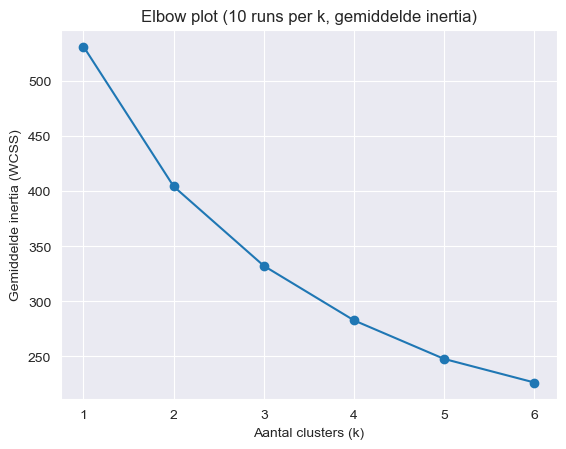

In [16]:
k_means_elbow(df1)

In [17]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(df1)
labels_kmeans_1 = kmeans.labels_

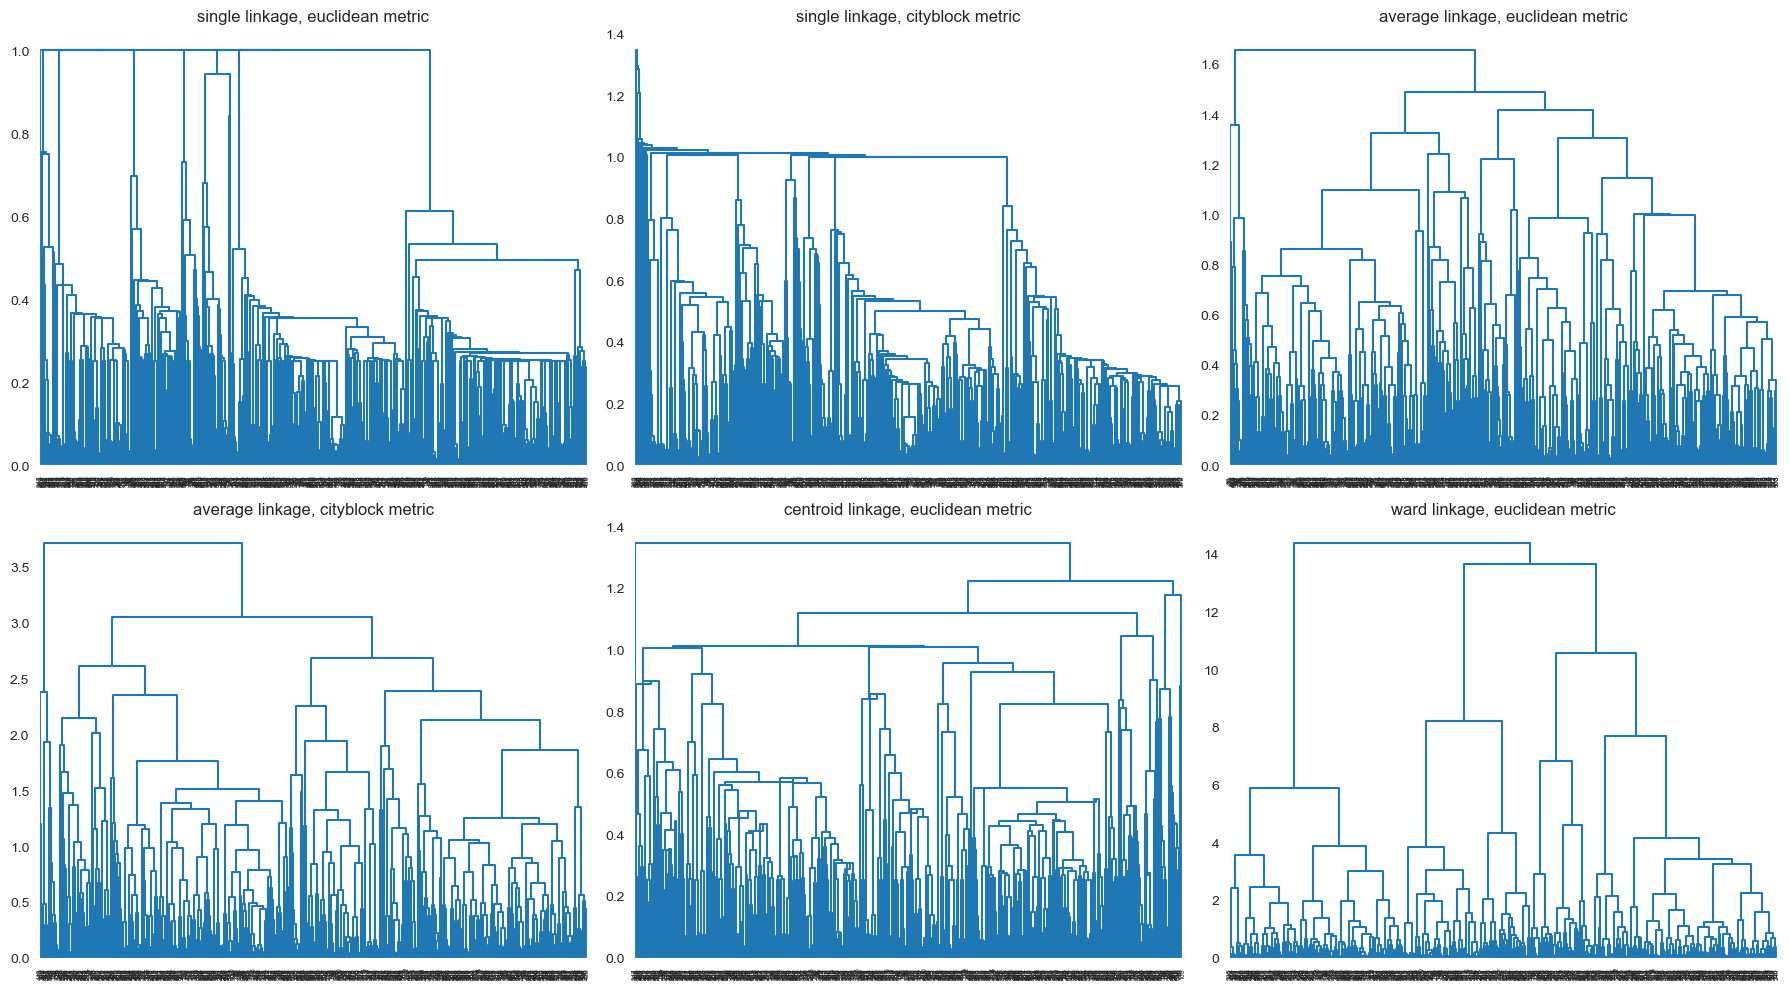

In [51]:
hierarchisch(df1)

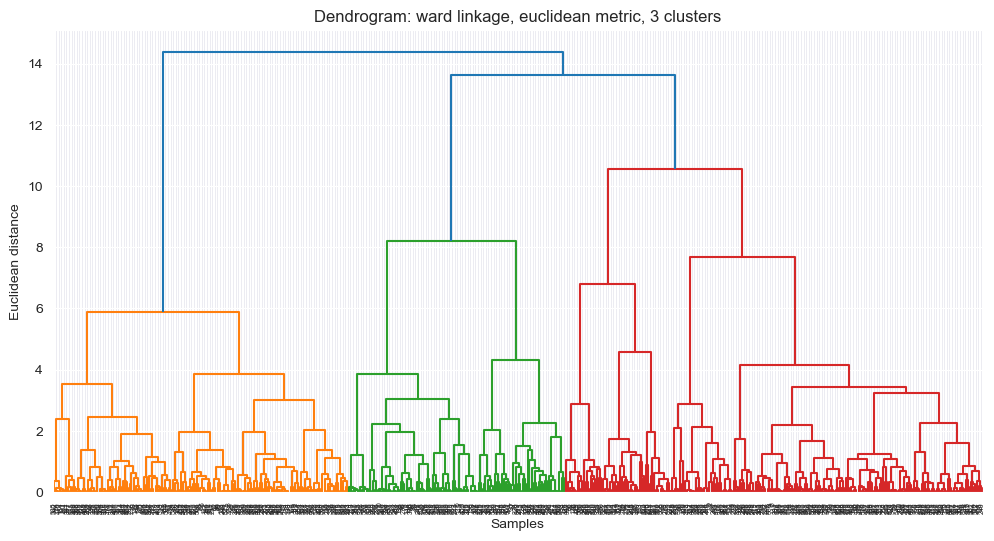

In [52]:
labels_hc_1 = dendogram(df1, method = "ward", metric = "euclidean", n_clusters = 3)

In [22]:
del_var = ['free_time','alcohol_weekday','alcohol_weekend','internet_access']
df2 = df1.drop(columns = del_var)

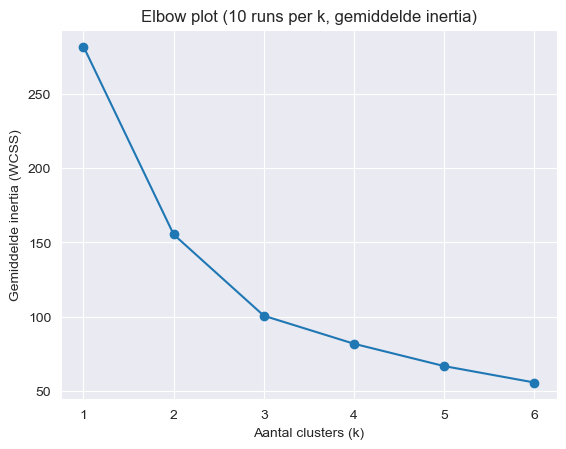

In [23]:
k_means_elbow(df2)

In [24]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(df2)
labels_kmeans_2 = kmeans.labels_

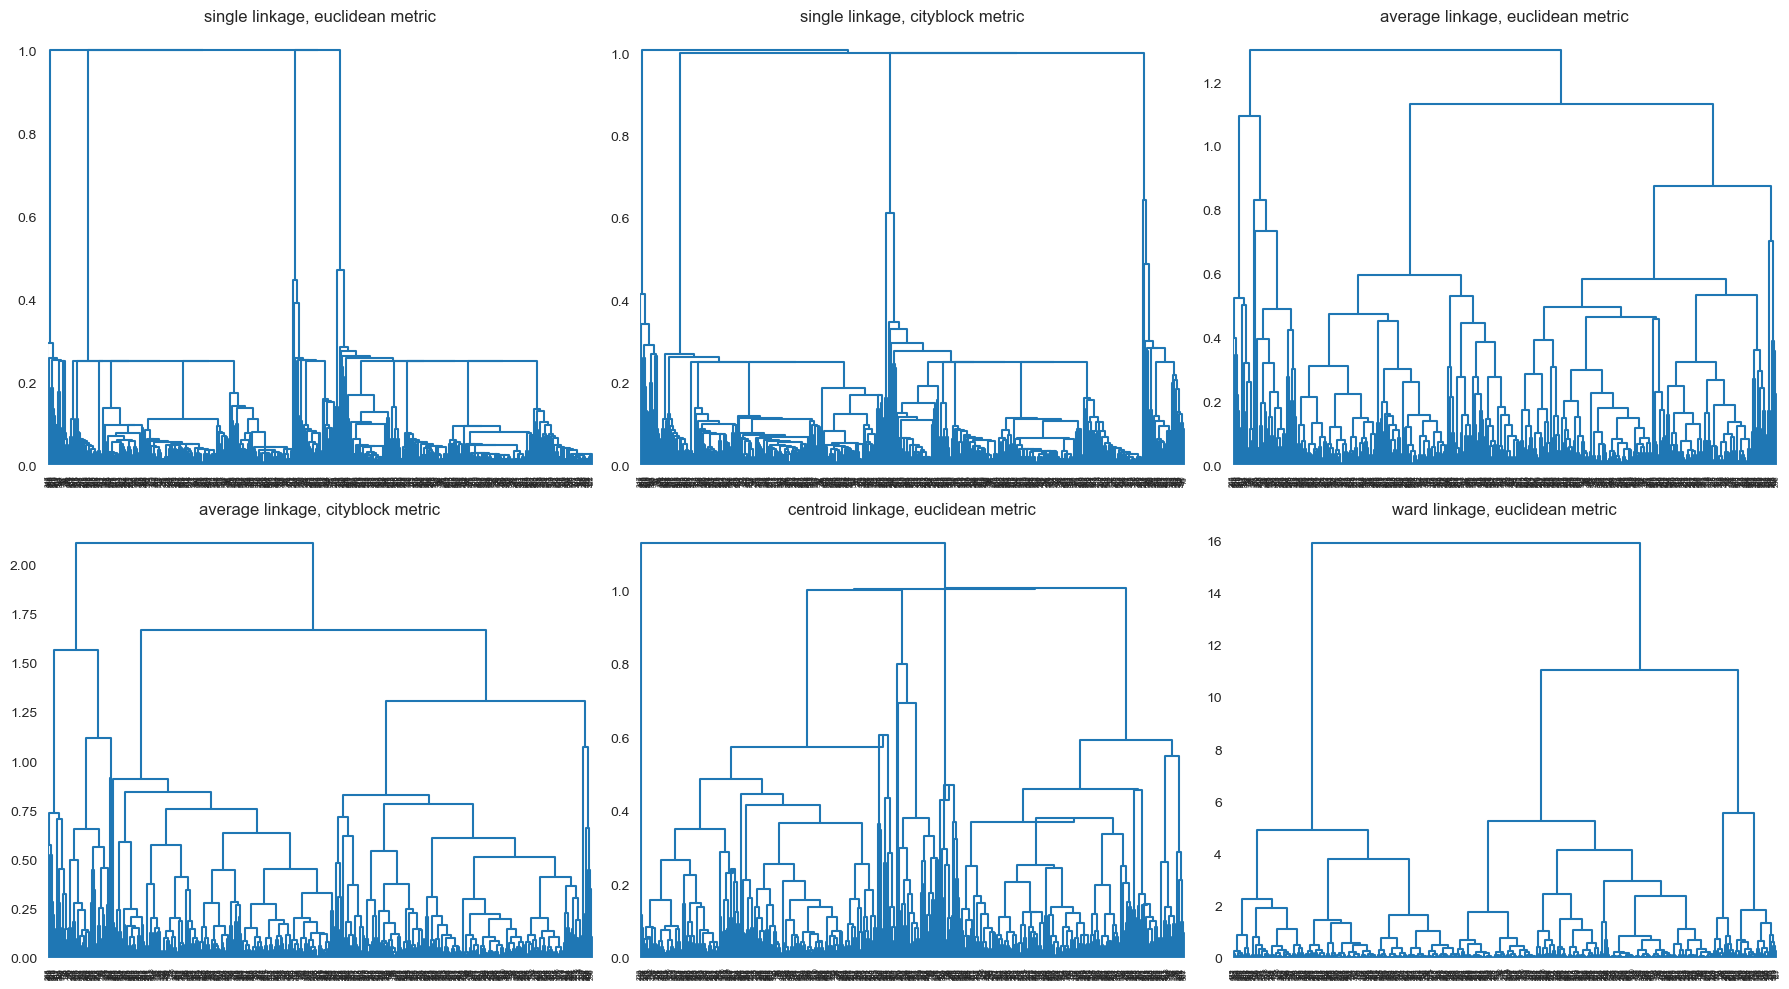

In [346]:
hierarchisch(df2)

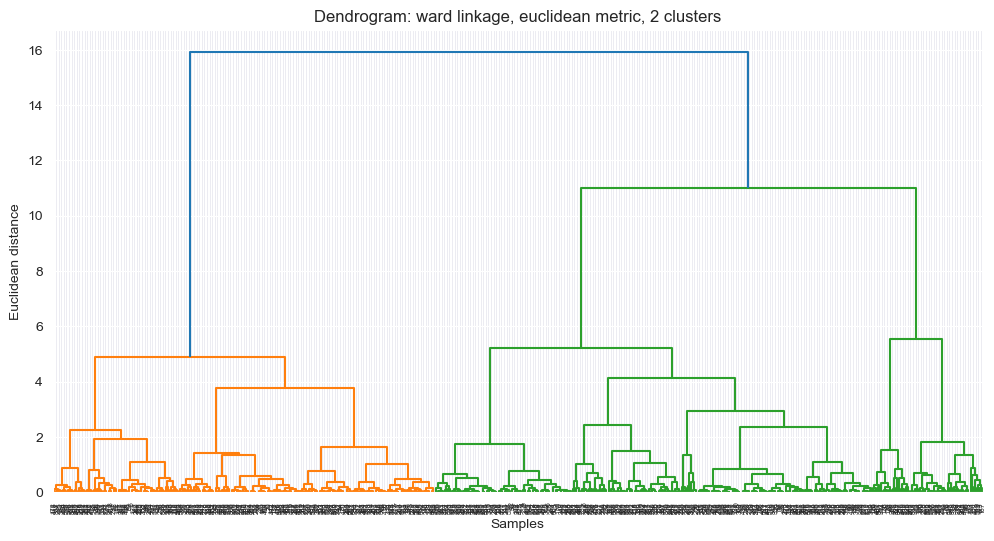

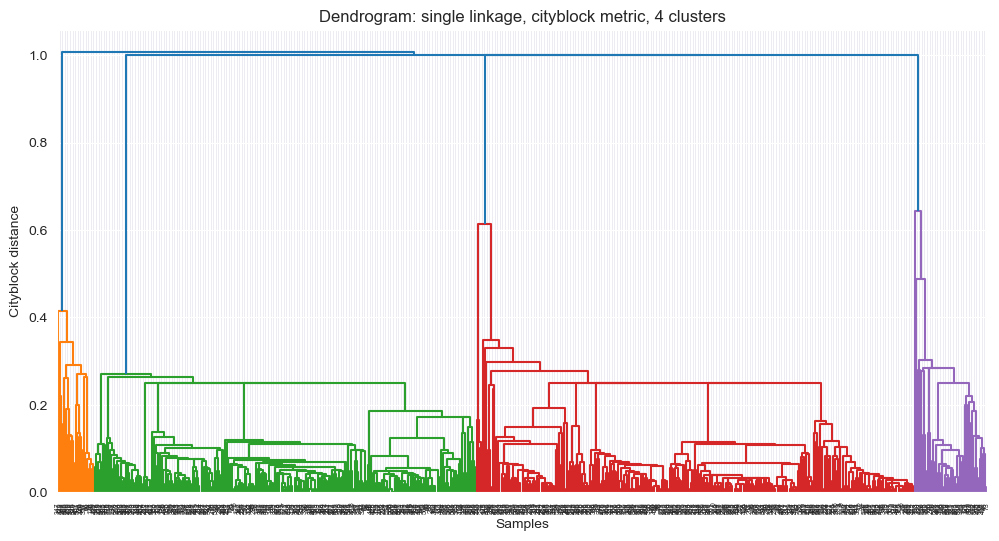

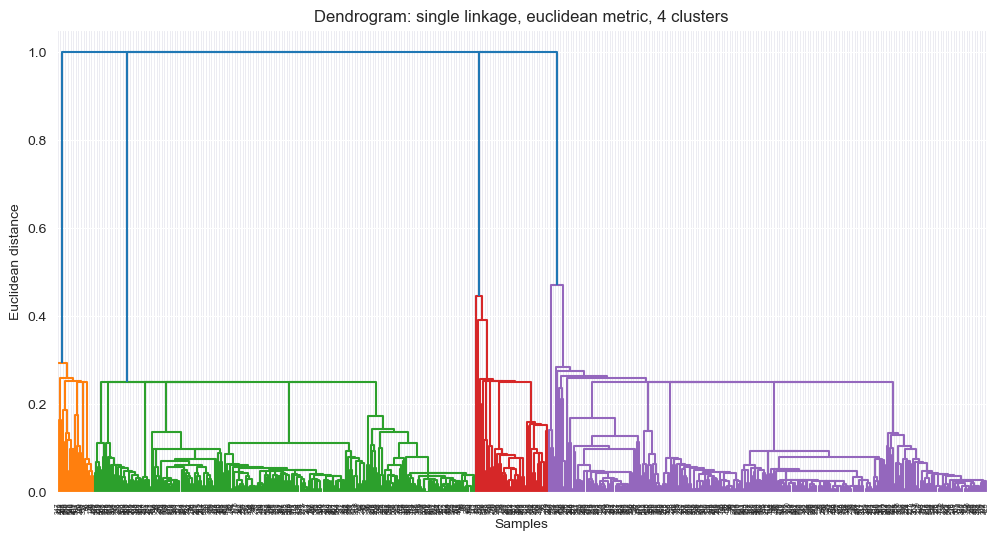

In [53]:
labels_hc_2 = dendogram(df2, method = "ward", metric = "euclidean", n_clusters = 2)
labels_hc_3 = dendogram(df2, method = "single", metric = "cityblock", n_clusters = 4)
labels_hc_4 = dendogram(df2, method = "single", metric = "euclidean", n_clusters = 4)

# titel

In [ ]:
model_km1 = (df1, 3)
model_km2 = (df2, 3)
model_hc1 = (df1, 3, 'ward', 'euclidean')
model_hc2 = (df2, 2, 'ward', 'euclidean')
model_hc3 = (df2, 4, 'single', 'cityblock')
model_hc4 = (df2, 4, 'single', 'euclidean')

In [58]:
results = []

# KMeans
scores = stability_bootstrap_kmeans(df1, 3)
results.append({'Model': 'KMeans_df1_k=3', 'Mean_ARI': round(np.mean(scores), 2)})

scores = stability_bootstrap_kmeans(df2, 3)
results.append({'Model': 'KMeans_df2_k=3', 'Mean_ARI': round(np.mean(scores), 2)})

# Hiërarchisch clusteren
scores = stability_bootstrap_hc(df1, 'ward', 'euclidean', 3)
results.append({'Model': 'HC_df1_ward_euclidean_k=3', 'Mean_ARI': round(np.mean(scores), 2)})

scores = stability_bootstrap_hc(df2, 'ward', 'euclidean', 2)
results.append({'Model': 'HC_df2_ward_euclidean_k=2', 'Mean_ARI': round(np.mean(scores), 2)})

scores = stability_bootstrap_hc(df2, 'single', 'cityblock', 4)
results.append({'Model': 'HC_df2_single_euclidean_k=4', 'Mean_ARI': round(np.mean(scores), 2)})

scores = stability_bootstrap_hc(df2, 'single', 'euclidean', 4)
results.append({'Model': 'HC_df2_single_cityblock_k=4', 'Mean_ARI': round(np.mean(scores), 2)})

results_df = pd.DataFrame(results)
print(results_df)

The Adjusted Rand Index for stability of k-means is: 0.728
The Adjusted Rand Index for stability of k-means is: 0.791
The Adjusted Rand Index for stability of hierarchical clustering (ward, euclidean) is: 0.885
The Adjusted Rand Index for stability of hierarchical clustering (ward, euclidean) is: 1.000
The Adjusted Rand Index for stability of hierarchical clustering (single, cityblock) is: 1.000
The Adjusted Rand Index for stability of hierarchical clustering (single, euclidean) is: 1.000
                         Model  Mean_ARI
0               KMeans_df1_k=3      0.73
1               KMeans_df2_k=3      0.79
2    HC_df1_ward_euclidean_k=3      0.89
3    HC_df2_ward_euclidean_k=2      1.00
4  HC_df2_single_euclidean_k=4      1.00
5  HC_df2_single_cityblock_k=4      1.00


In [59]:
# voer robuustheidsanalyse k-means uit
ari_kmeans_1 = kmeans_feature_robustness(df1, n_clusters=3, noise_level=0.05, n_runs=10)
ari_kmeans_2 = kmeans_feature_robustness(df2, n_clusters=3, noise_level=0.05, n_runs=10)
ari_hc1 = hc_feature_robustness(df1,'ward','euclidean',3,noise_level=0.05, n_runs = 10)
ari_hc2 = hc_feature_robustness(df2,'ward','euclidean',2,noise_level=0.05, n_runs = 10)
ari_hc3 = hc_feature_robustness(df2,'single','cityblock',4,noise_level=0.05, n_runs = 10)
ari_hc4 = hc_feature_robustness(df2,'single','euclidean',4,noise_level=0.05, n_runs = 10)


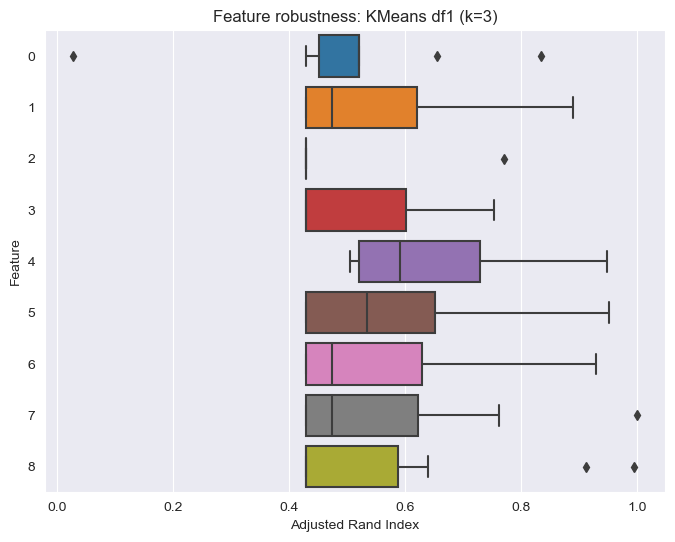

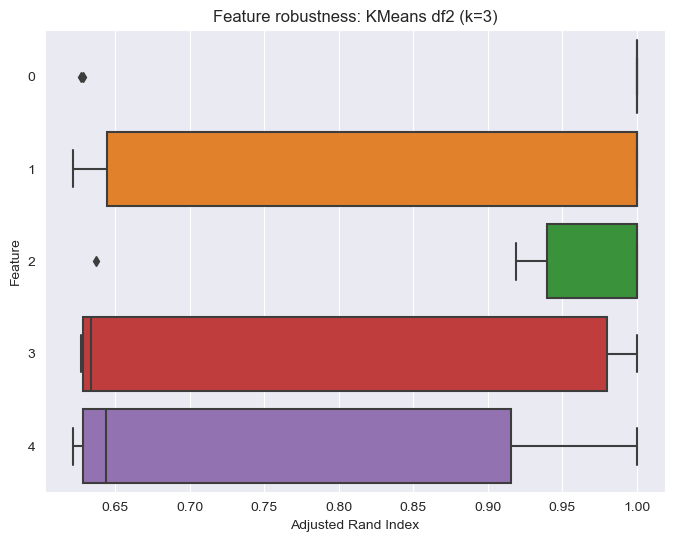

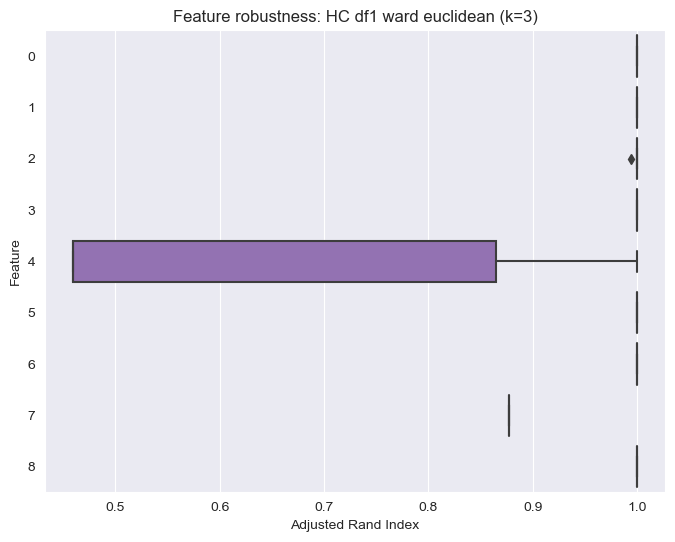

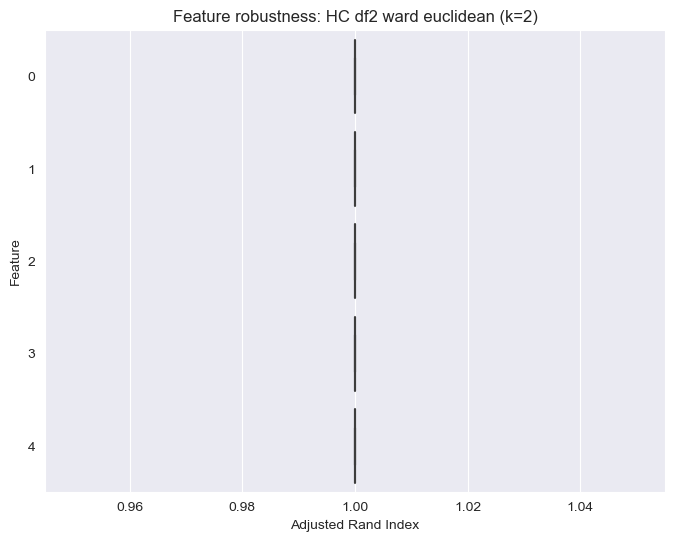

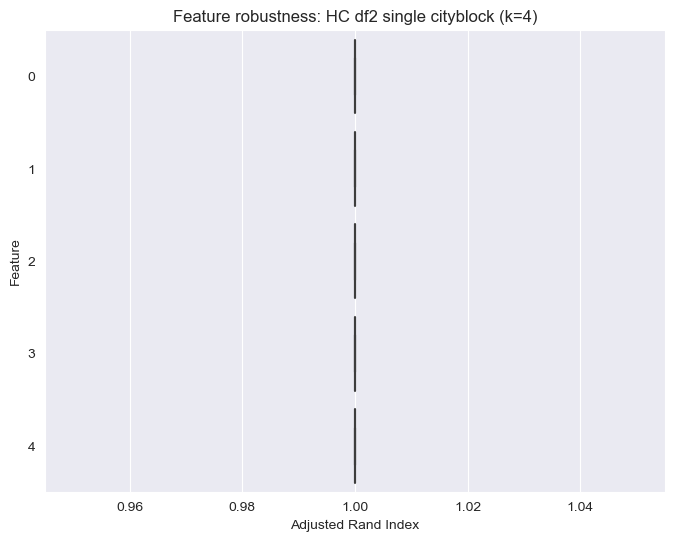

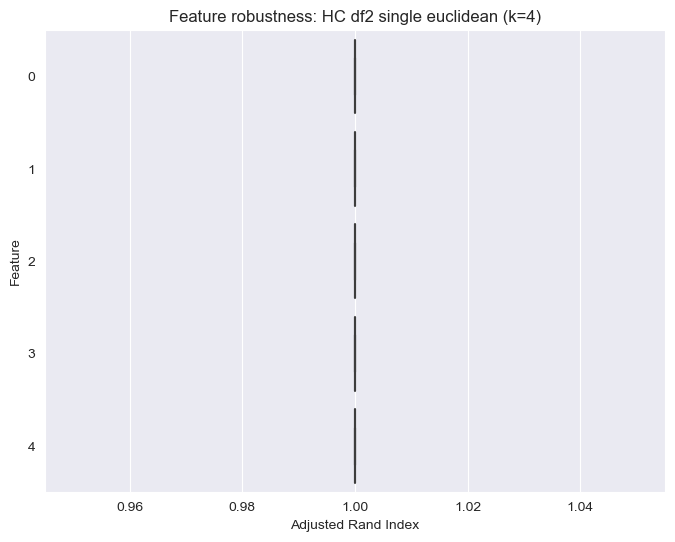

In [60]:
models = [
    (ari_kmeans_1, "KMeans df1 (k=3)"),
    (ari_kmeans_2, "KMeans df2 (k=3)"),
    (ari_hc1, "HC df1 ward euclidean (k=3)"),
    (ari_hc2, "HC df2 ward euclidean (k=2)"),
    (ari_hc3, "HC df2 single cityblock (k=4)"),
    (ari_hc4, "HC df2 single euclidean (k=4)")
]

# 6 plots maken
for ari_dict, title in models:
    # omzetten naar DataFrame
    ari_df = pd.DataFrame(ari_dict)
    
    # boxplot
    plt.figure(figsize=(8,6))
    sns.boxplot(data=ari_df, orient='h')
    plt.xlabel("Adjusted Rand Index")
    plt.ylabel("Feature")
    plt.title(f"Feature robustness: {title}")
    plt.show()

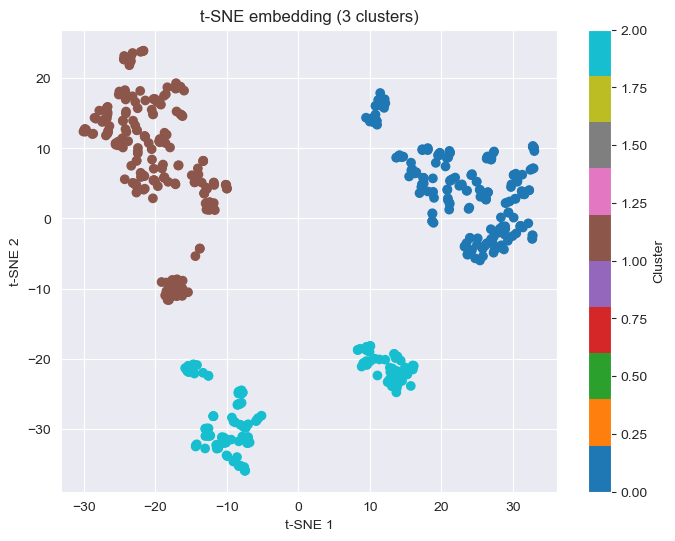

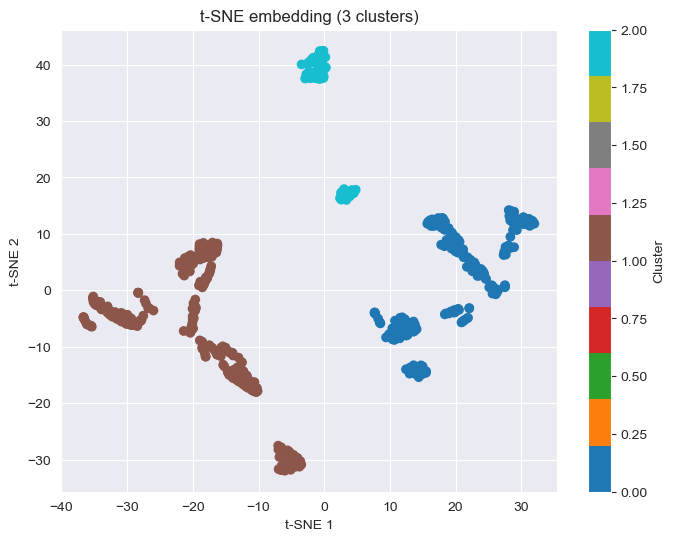

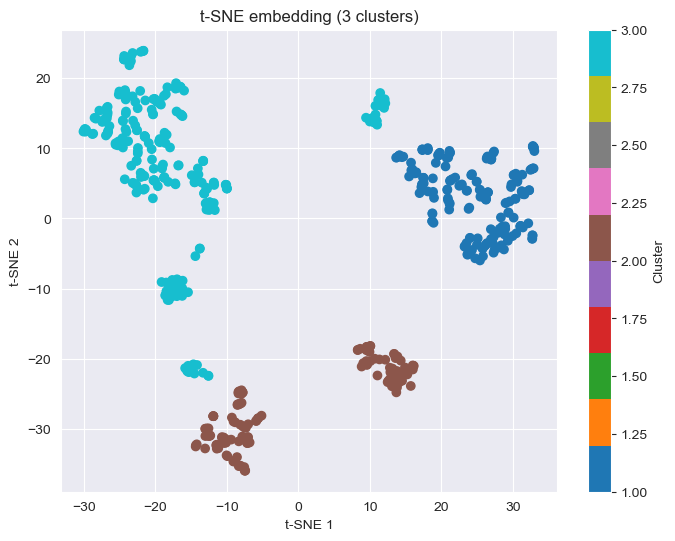

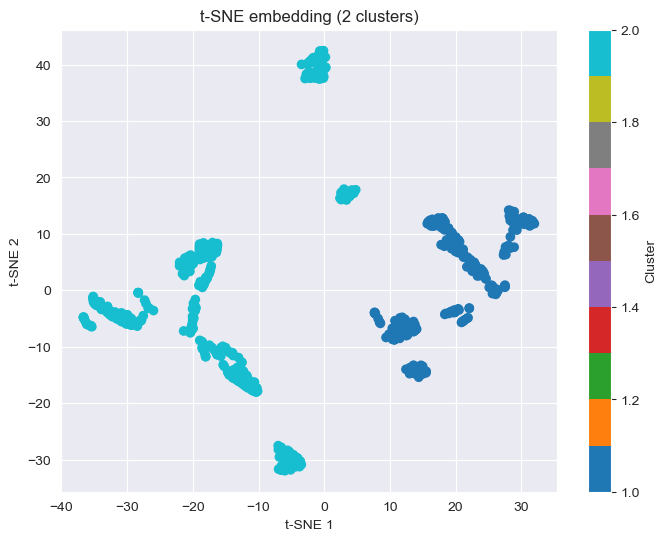

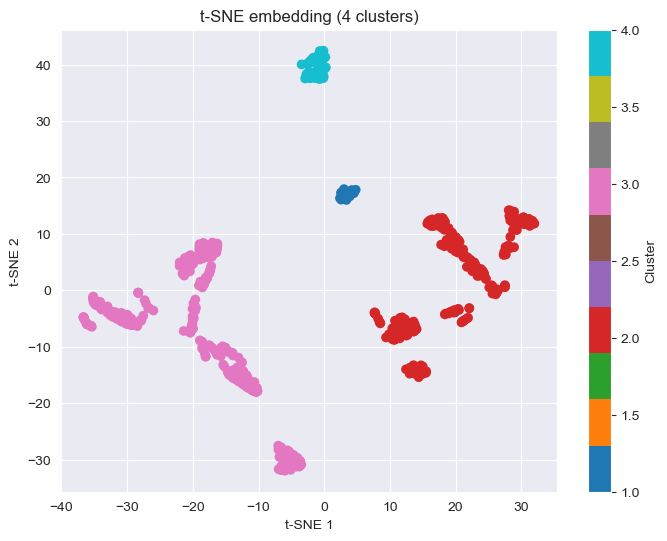

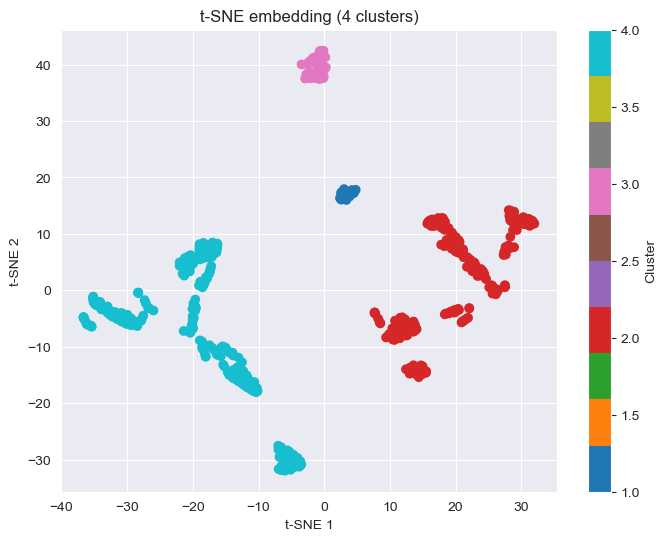

In [73]:
t_sne_embedding(df1, labels_kmeans_1)
t_sne_embedding(df2, labels_kmeans_2)
t_sne_embedding(df1, labels_hc_1)
t_sne_embedding(df2, labels_hc_2)
t_sne_embedding(df2, labels_hc_3)
t_sne_embedding(df2, labels_hc_4)

In [92]:
df2

extra_paid_classes  school_absences  social_outings  support_school  \
0                   0.0           0.0000            0.50             0.0   
1                   0.0           0.0000            0.75             0.0   
2                   0.0           0.1000            0.75             0.0   
3                   1.0           0.0000            0.50             0.0   
4                   0.0           0.2500            0.75             0.0   
..                  ...              ...             ...             ...   
568                 1.0           0.1625            1.00             0.0   
569                 0.0           0.0000            0.00             0.0   
570                 0.0           0.1375            0.50             0.0   
571                 0.0           0.0000            0.50             0.0   
572                 0.0           0.0500            0.75             1.0   

     weekly_study_hours  
0              0.069444  
1              0.256944  
2              0.111111  
3              0.826389  
4              0.291667  
..                  ...  
568            0.166667  
569            0.138889  
570            0.152778  
571            0.298611  
572            0.111111  

[573 rows x 5 columns]

In [100]:
df1_jitter = df1.copy()
df2_jitter = df2.copy()

jitter_ord = 0.2   # kleine jitter voor ordinale variabelen
jitter_bin = 0.05  # nog kleinere jitter voor binaire variabelen

ord_var1 = ['alcohol_weekday','alcohol_weekend','free_time','social_outings']
bin_var1 = ['extra_paid_classes','internet_access','support_school']

ord_var2 = ['social_outings']
bin_var2 = ['extra_paid_classes','support_school']

for col in ord_var1:
    df1_jitter[col] = df1_jitter[col] + np.random.uniform(-jitter_ord, jitter_ord, size=len(df1_jitter))

for col in bin_var1:
    df1_jitter[col] = df1_jitter[col] + np.random.uniform(-jitter_bin, jitter_bin, size=len(df1_jitter))

for col in ord_var2:
    df2_jitter[col] = df2_jitter[col] + np.random.uniform(-jitter_ord, jitter_ord, size=len(df2_jitter))

for col in bin_var2:
    df2_jitter[col] = df2_jitter[col] + np.random.uniform(-jitter_bin, jitter_bin, size=len(df2_jitter))




In [101]:
df1_jitter

alcohol_weekday  alcohol_weekend  extra_paid_classes  free_time  \
0           0.030179         0.149399            0.046610   1.005877   
1           0.192282         0.440373           -0.038581   0.324606   
2           0.598947         0.462474           -0.048475   0.608011   
3          -0.131592        -0.165254            0.970371   0.482993   
4           0.178739        -0.199824            0.039560   0.775178   
..               ...              ...                 ...        ...   
568         0.306494         0.793780            0.997658   0.219526   
569        -0.055918         0.046031           -0.025261   0.193851   
570        -0.008735         0.689170           -0.005875   0.338519   
571         0.025647         0.307658            0.032542   0.881524   
572        -0.186267         0.190146            0.001742   0.419606   

     internet_access  school_absences  social_outings  support_school  \
0           0.019428           0.0000        0.638218       -0.049741   
1           0.004393           0.0000        0.690486        0.022489   
2           0.990811           0.1000        0.868082        0.039866   
3           1.012223           0.0000        0.407602        0.018607   
4           0.963756           0.2500        0.802993        0.026199   
..               ...              ...             ...             ...   
568         1.028220           0.1625        0.970471       -0.025955   
569        -0.011192           0.0000        0.104868        0.046363   
570         1.012193           0.1375        0.525427        0.033049   
571        -0.044989           0.0000        0.304625        0.027959   
572        -0.045735           0.0500        0.853312        0.978995   

     weekly_study_hours  
0              0.069444  
1              0.256944  
2              0.111111  
3              0.826389  
4              0.291667  
..                  ...  
568            0.166667  
569            0.138889  
570            0.152778  
571            0.298611  
572            0.111111  

[573 rows x 9 columns]

In [103]:
def pairplot(df, labels):
    input_data = df.copy()
    input_data.loc[:,'cluster'] = labels
    sns.pairplot(input_data, hue='cluster', palette='Set1')
    plt.show()

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


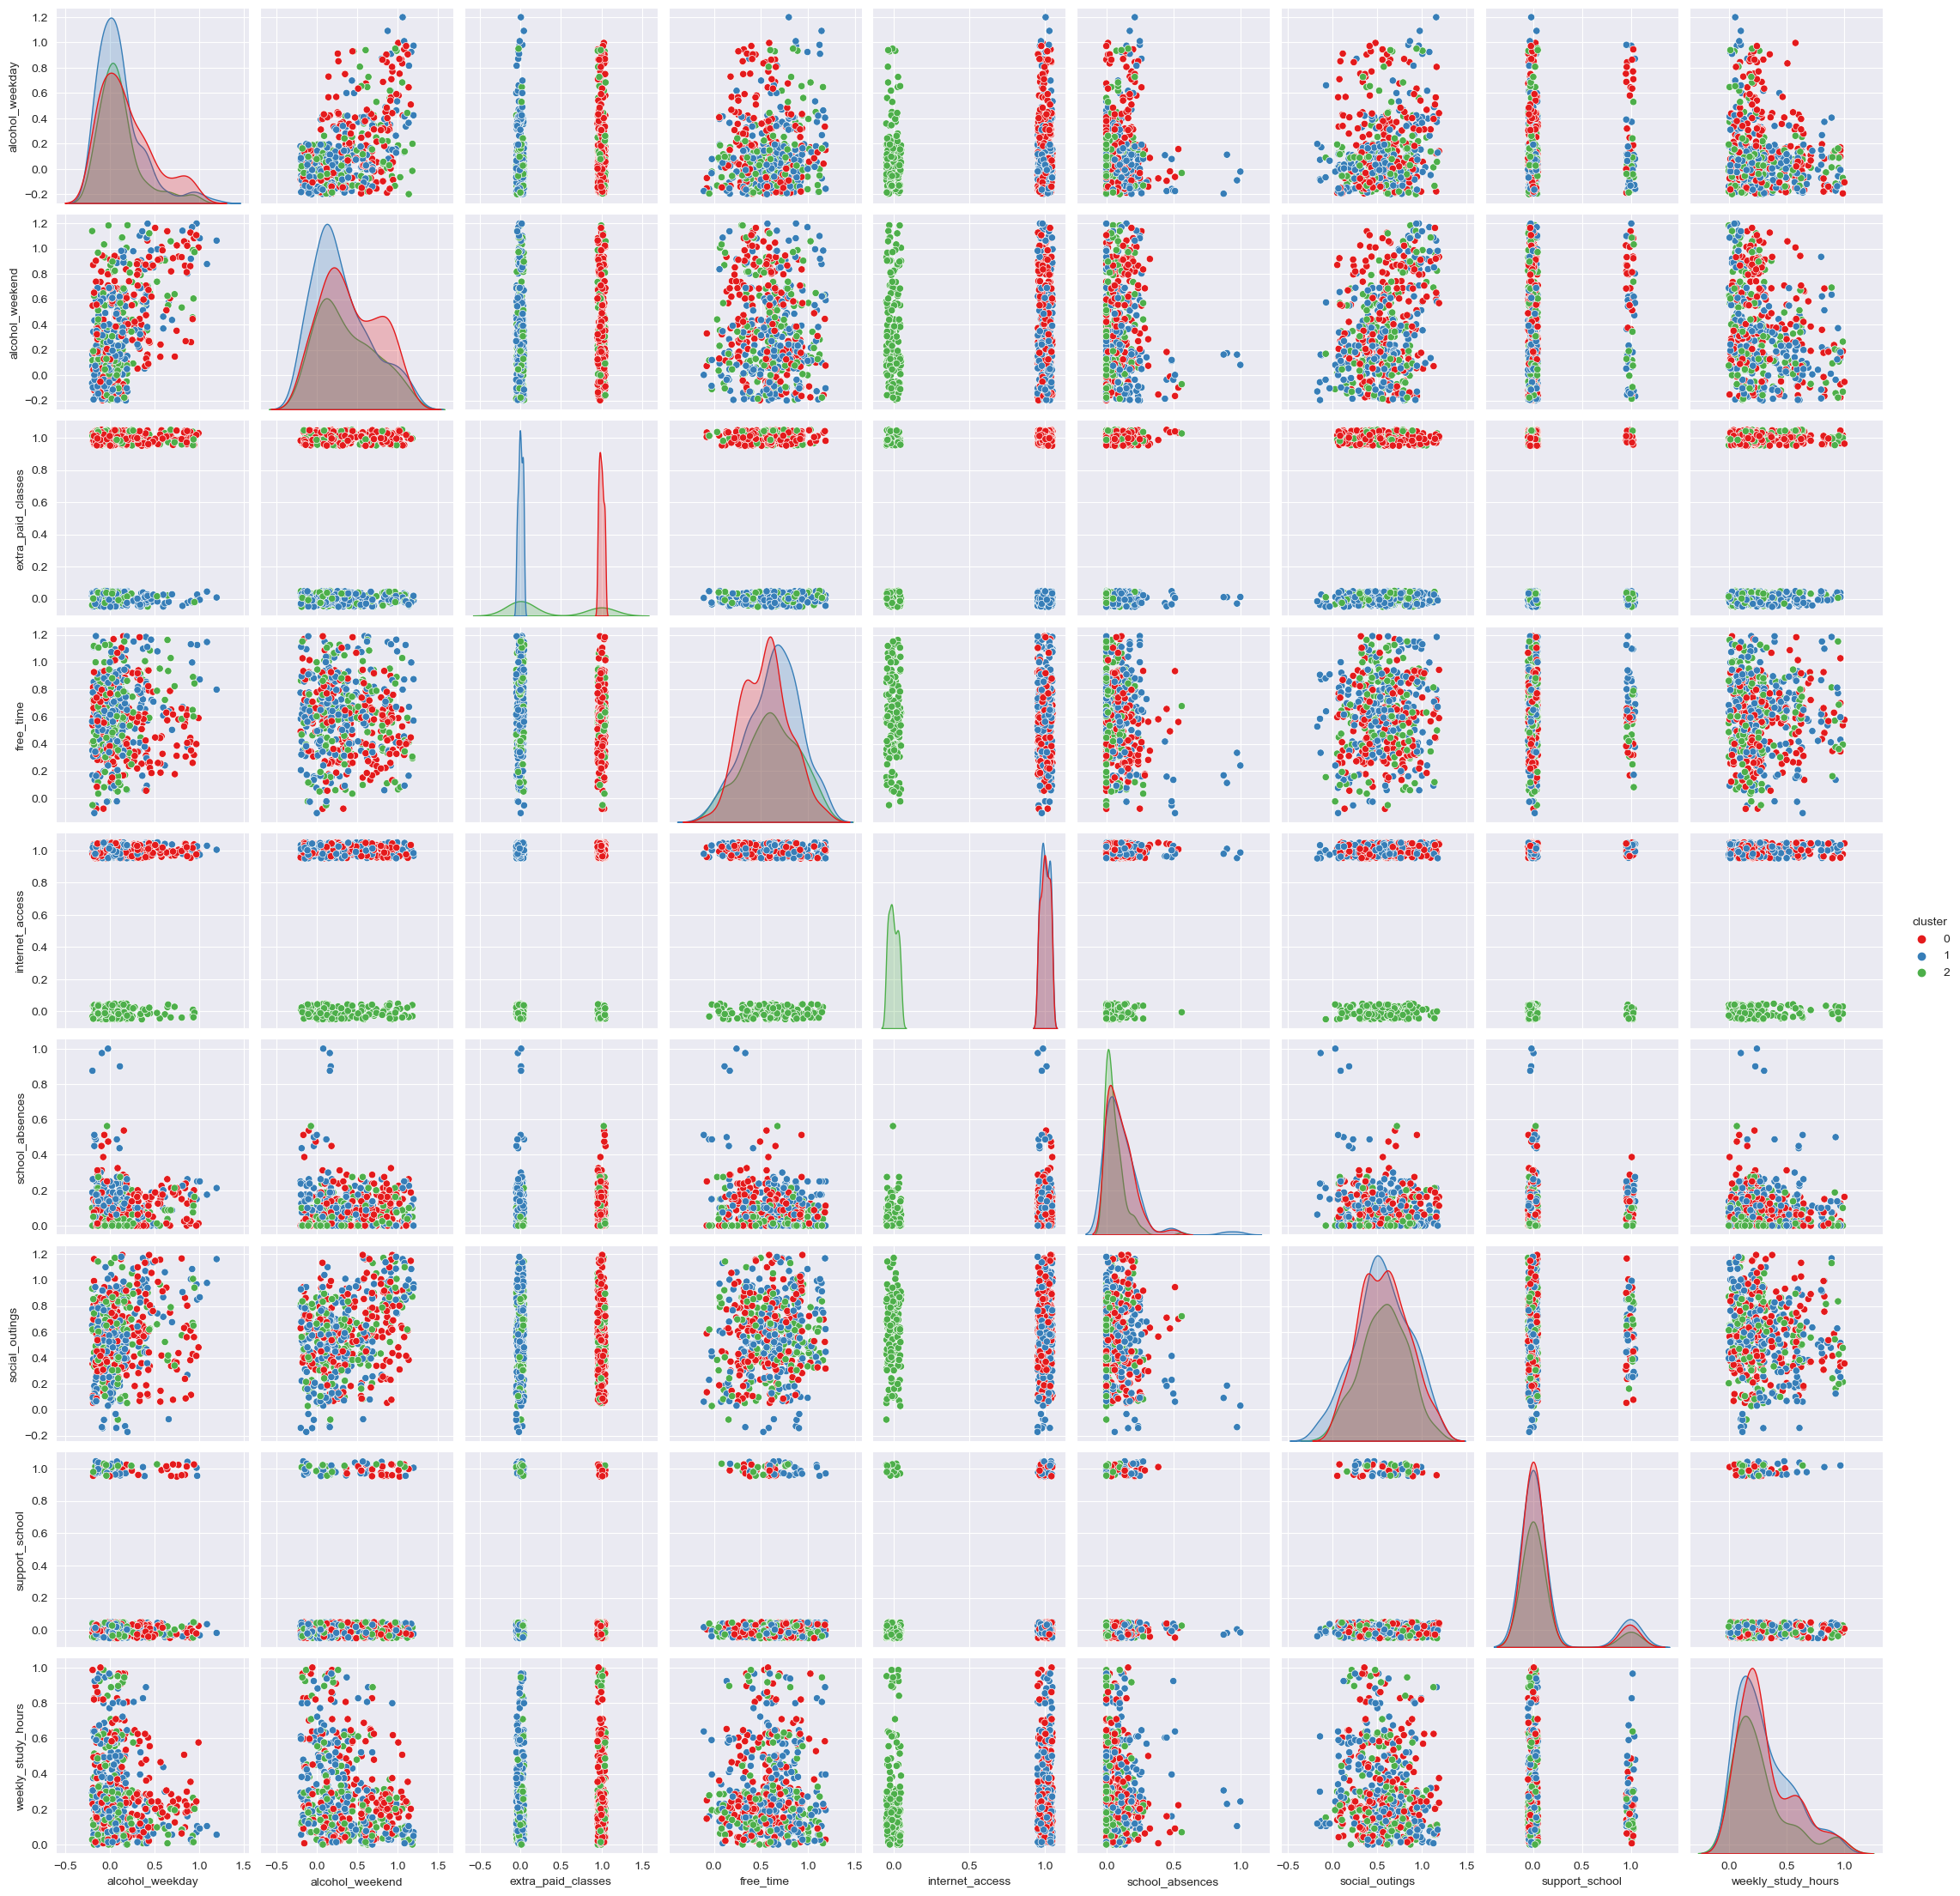

In [104]:
pairplot(df1_jitter, labels_kmeans_1)

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


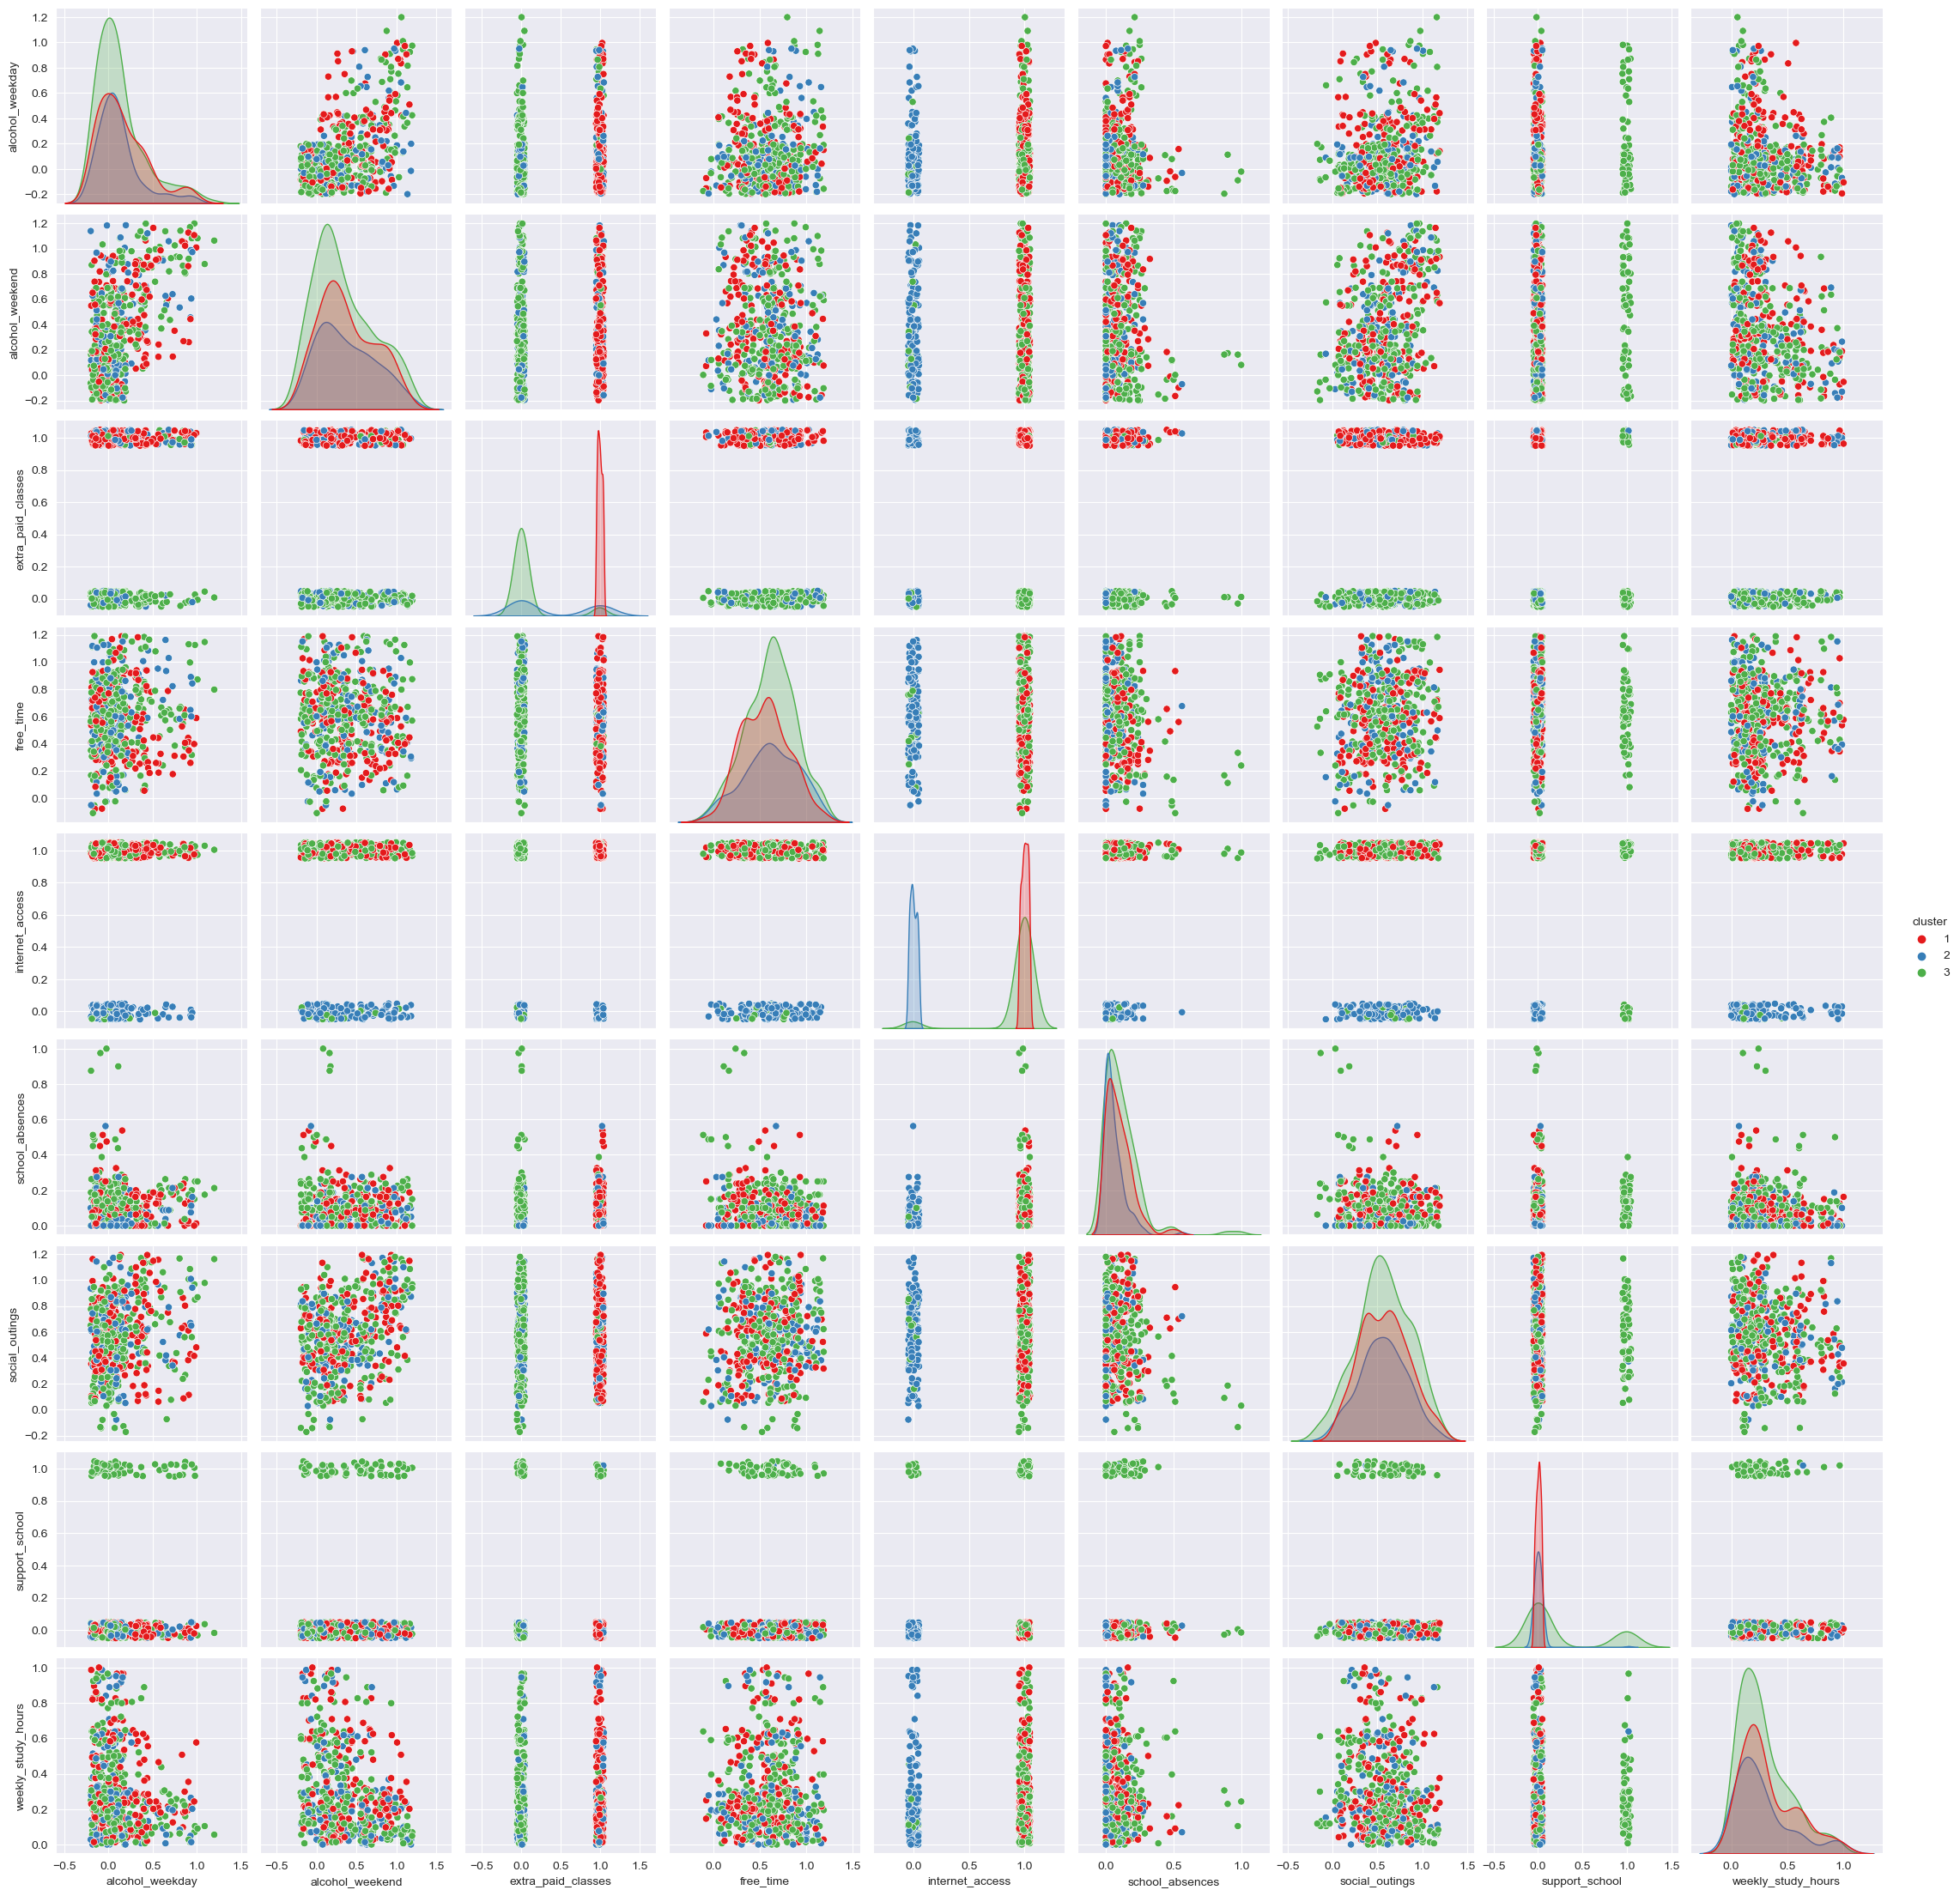

In [105]:
pairplot(df1_jitter, labels_hc_1)

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


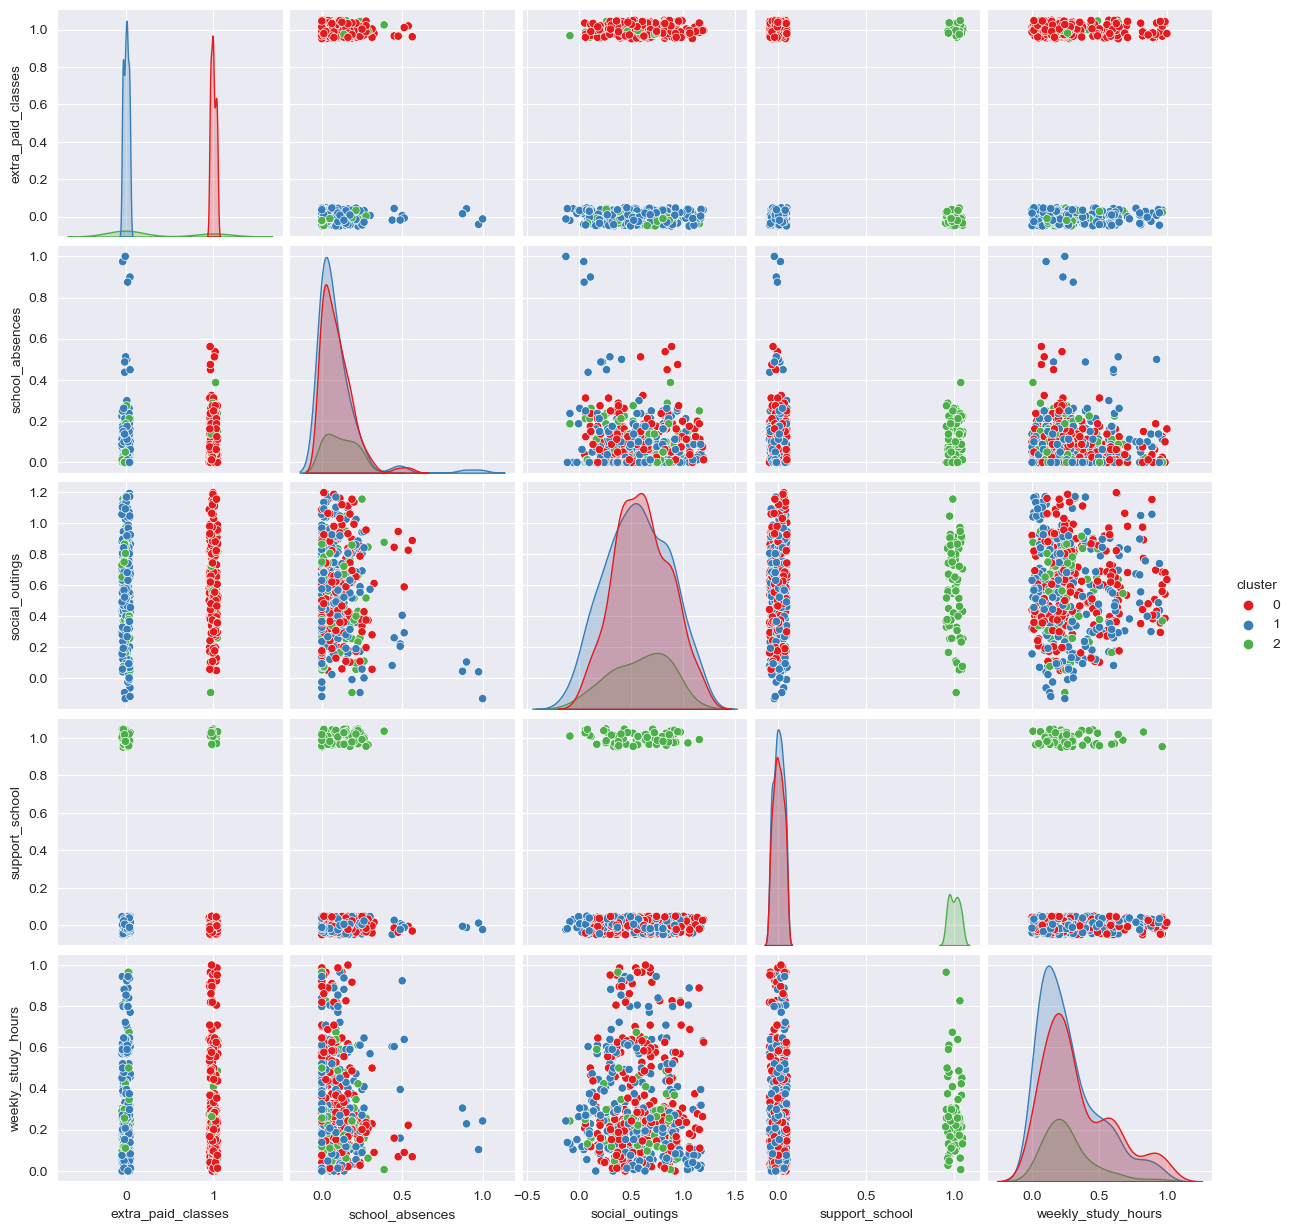

In [106]:
pairplot(df2_jitter, labels_kmeans_2)

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


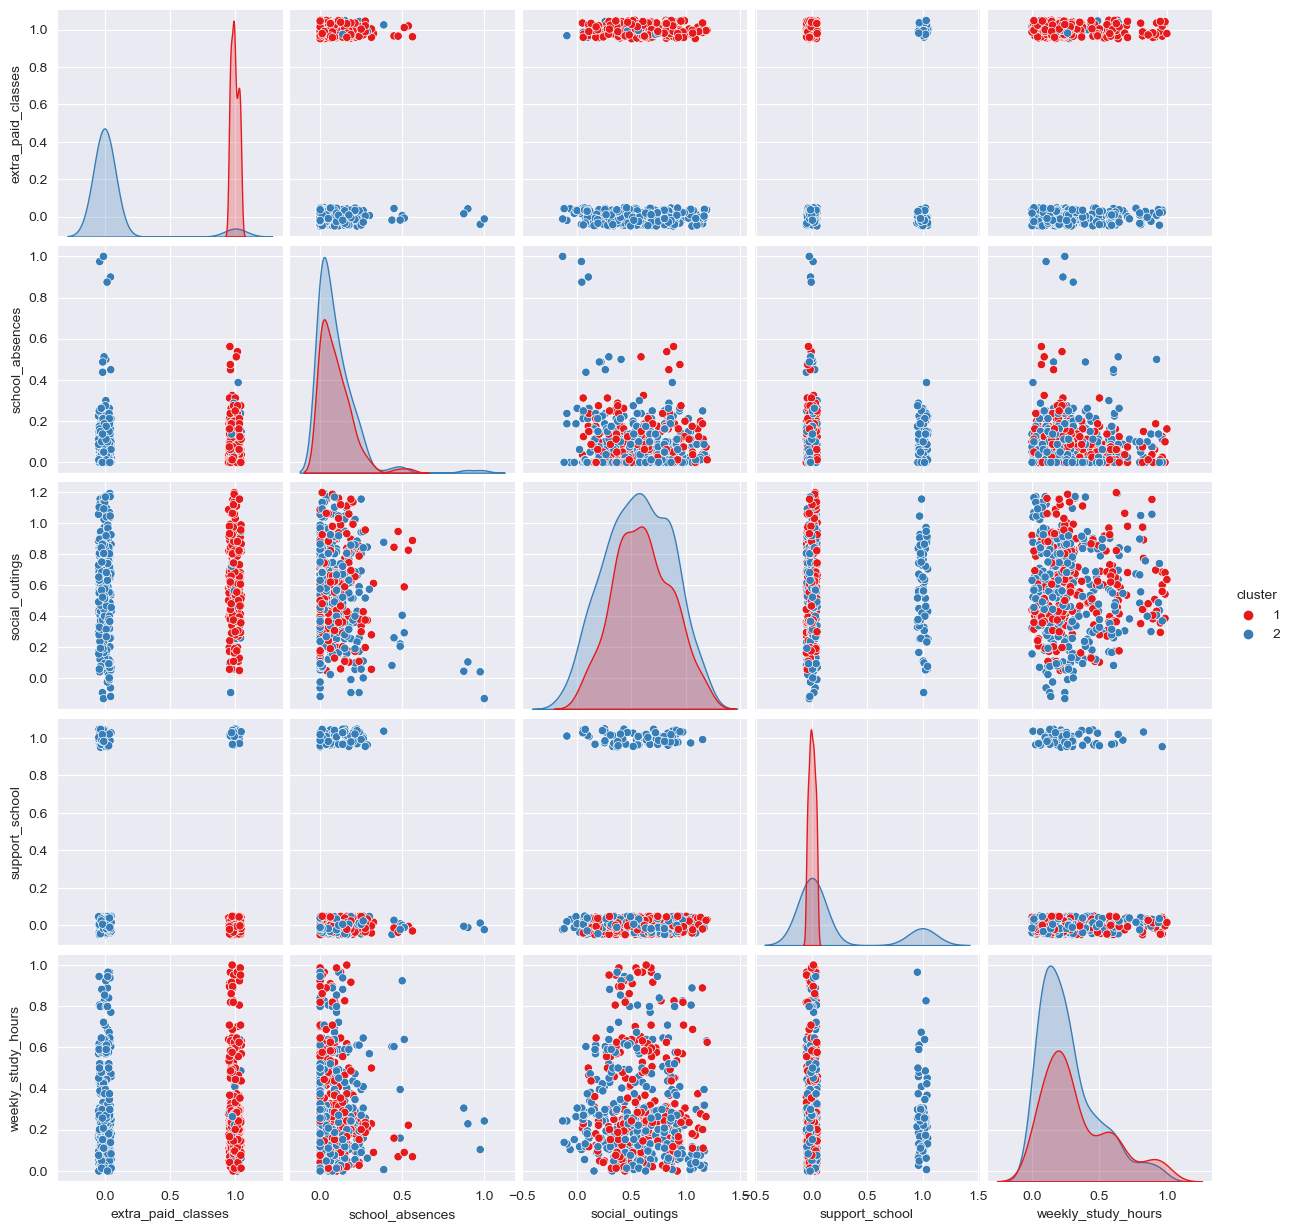

In [107]:
pairplot(df2_jitter, labels_hc_2)

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


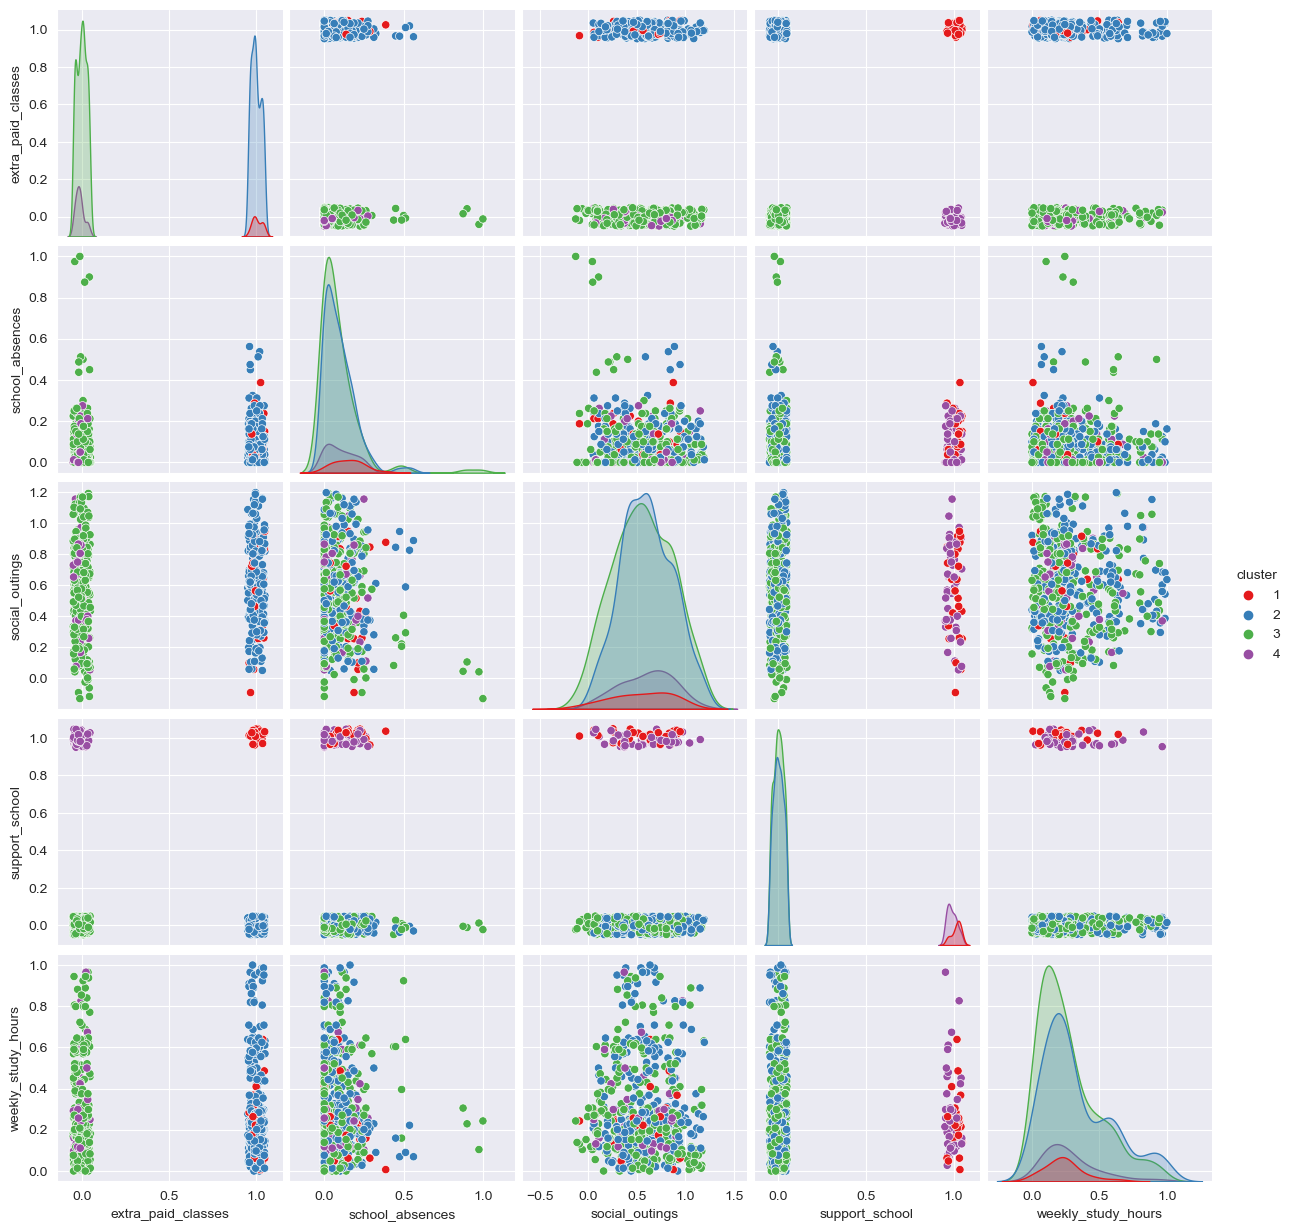

In [108]:
pairplot(df2_jitter, labels_hc_3)

c:\Users\lucas\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


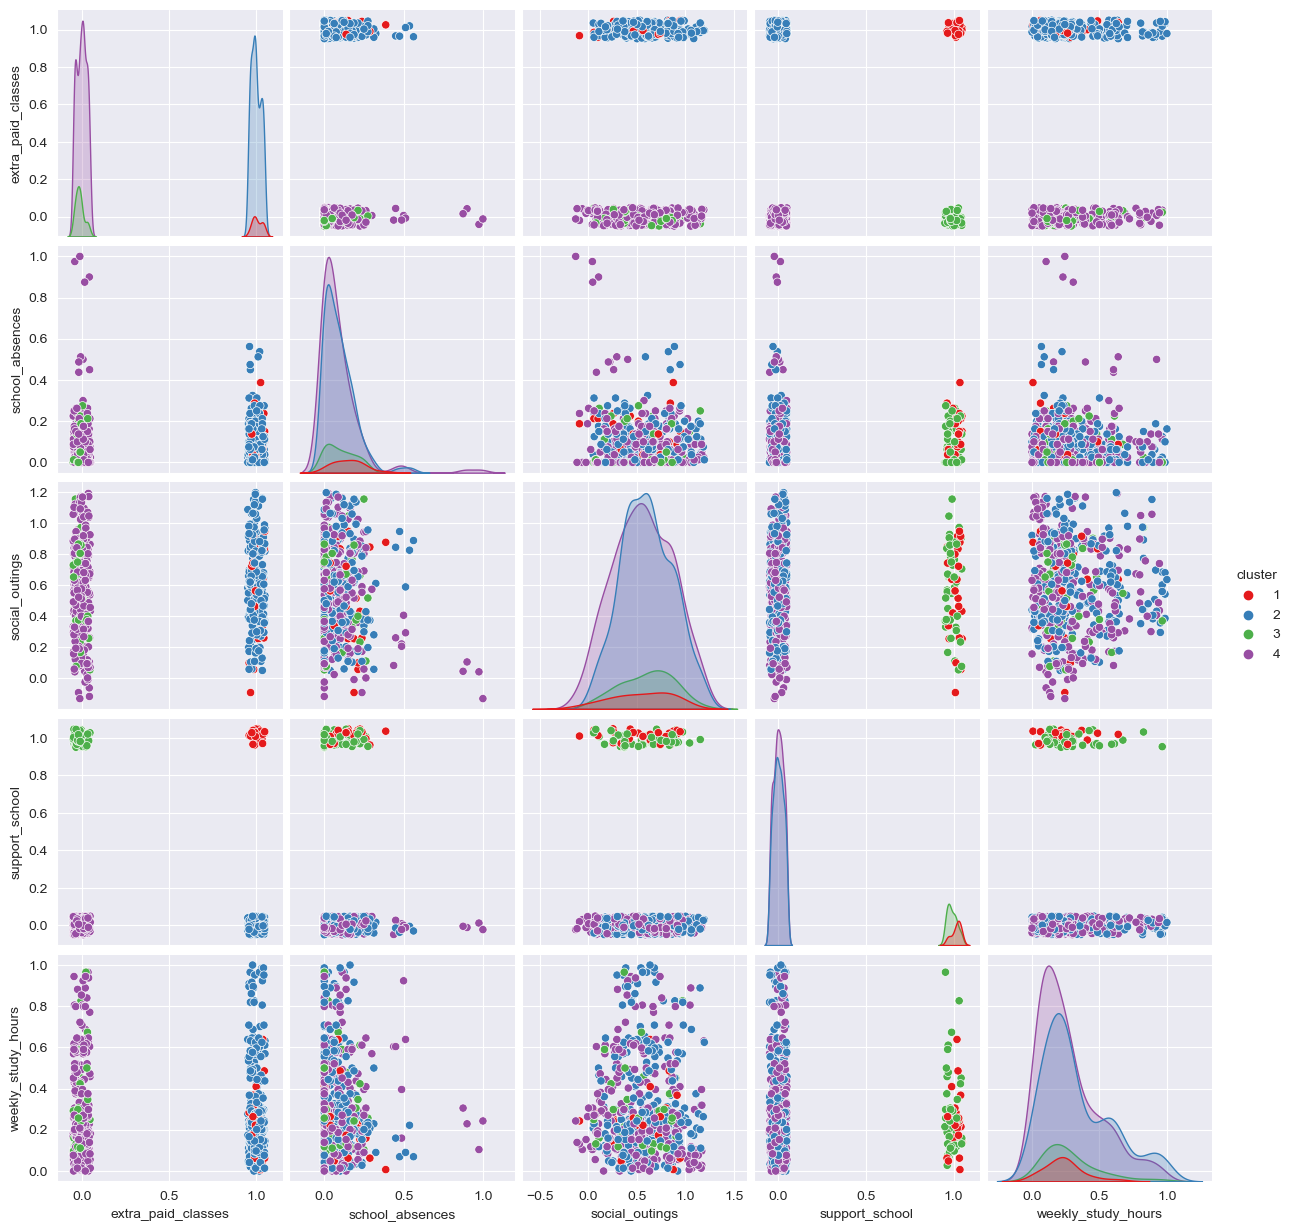

In [109]:
pairplot(df2_jitter, labels_hc_4)

In [122]:
def boxplot_doelvar(label, df):
    df = df.copy()
    df['Cluster'] = label
    
    # Selecteer relevante kolommen en zet ze in long-form
    features = ['grade_final', 'grade_period1', 'grade_period2']
    df_melted = df.melt(id_vars='Cluster', value_vars=features, var_name='Feature', value_name='Score')
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Feature', y='Score', hue='Cluster', data=df_melted, palette='Set1')
    plt.title('Distributie van cijfers per cluster')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

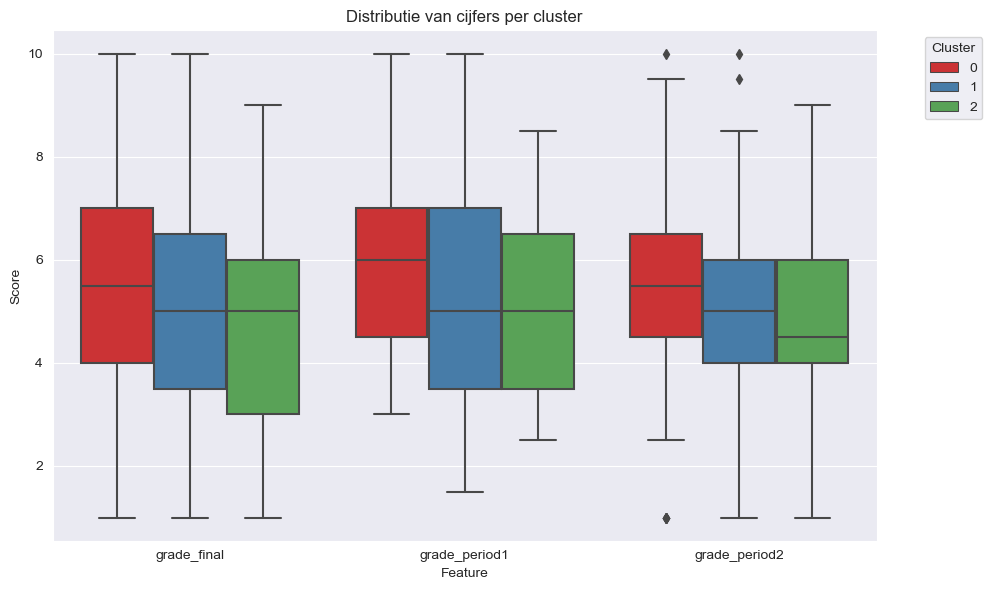

In [123]:
boxplot_doelvar(labels_kmeans_1, df_heel)

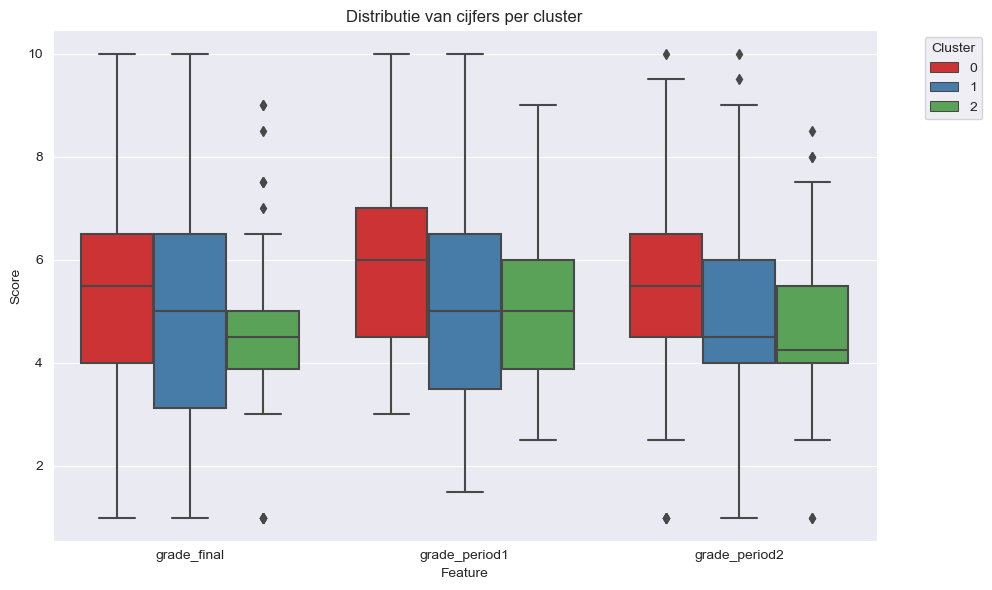

In [124]:
boxplot_doelvar(labels_kmeans_2, df_heel)

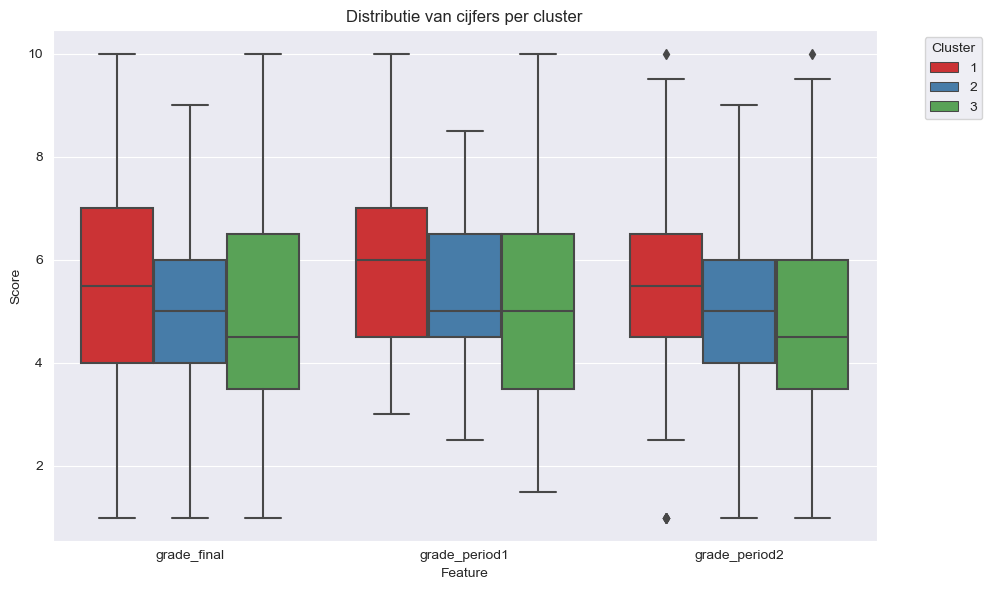

In [125]:
boxplot_doelvar(labels_hc_1, df_heel)

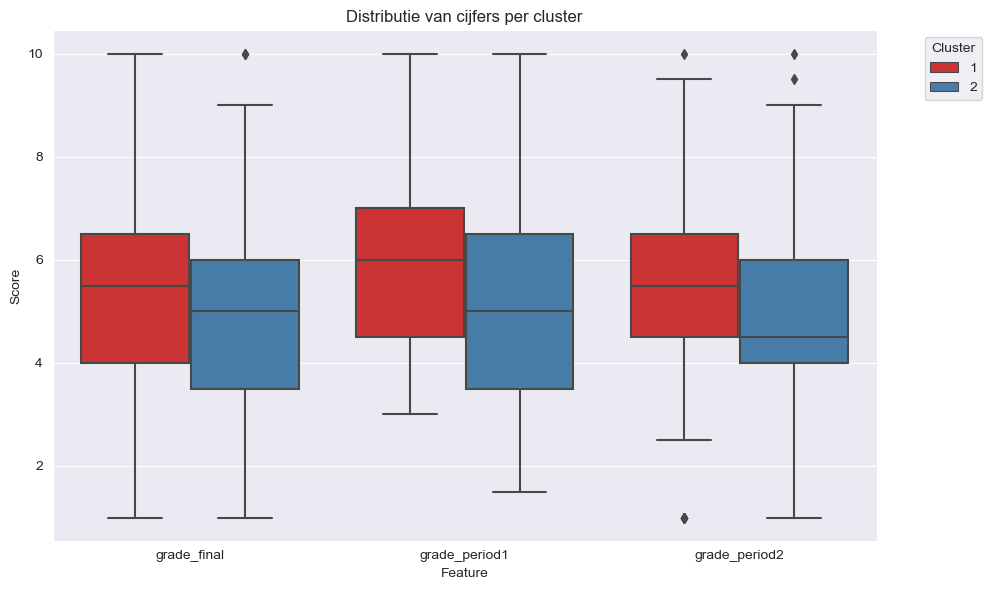

In [126]:
boxplot_doelvar(labels_hc_2, df_heel)

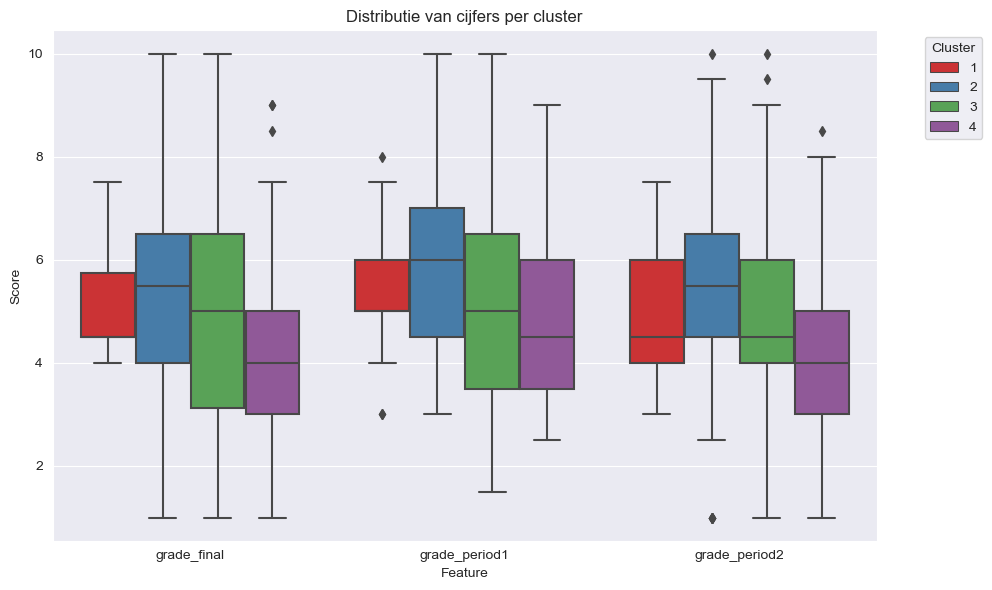

In [127]:
boxplot_doelvar(labels_hc_3, df_heel)

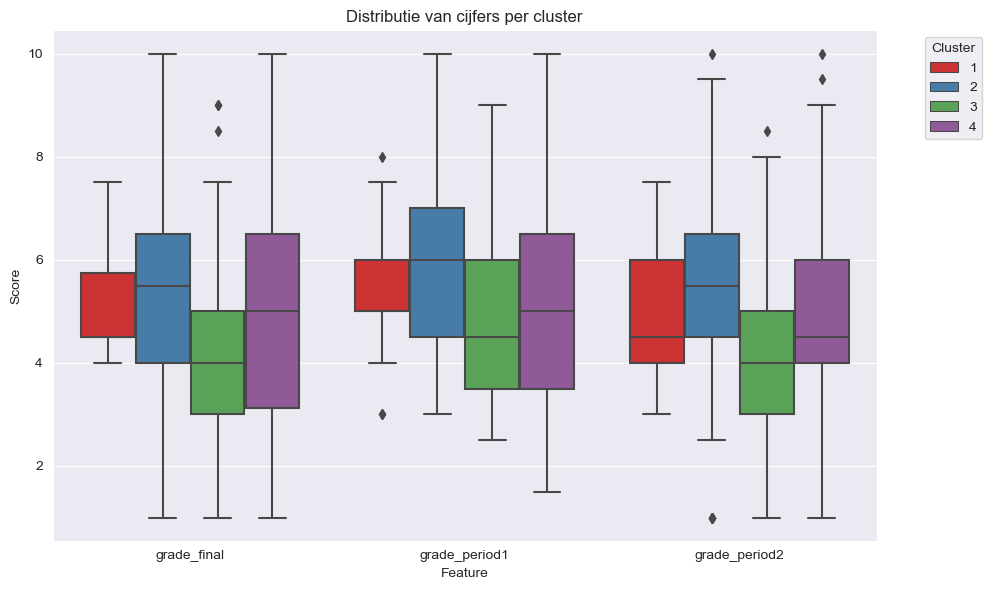

In [128]:
boxplot_doelvar(labels_hc_4, df_heel)